In [2]:
import os
import operator

import numpy as np
import pandas as pd
pd.options.display.max_colwidth = 200
import polars as pl

import seaborn as sns
import matplotlib.pyplot as plt

from clickhouse_driver import Client

client = Client('localhost', database="upthesisnumclientsdb")

In [3]:
%%time 

exp_data_sql = """
SELECT
	ex.*
FROM
	experiment ex
"""
exp_df = client.query_dataframe(exp_data_sql)
print(len(exp_df.exp_id.unique().tolist()))
print("\n".join(exp_df.exp_id.unique().tolist()))
print()
exp_df

16
updated_thesis_group_num_clients_1clients_noattacker_coap_https
updated_thesis_group_num_clients_1clients_noattacker_dtls_https
updated_thesis_group_num_clients_2clients_noattacker_coap_https
updated_thesis_group_num_clients_2clients_noattacker_dtls_https
updated_thesis_group_num_clients_3clients_noattacker_coap_https
updated_thesis_group_num_clients_3clients_noattacker_dtls_https
updated_thesis_group_num_clients_4clients_noattacker_coap_https
updated_thesis_group_num_clients_4clients_noattacker_dtls_https
updated_thesis_group_num_clients_5clients_noattacker_coap_https
updated_thesis_group_num_clients_5clients_noattacker_dtls_https
updated_thesis_group_num_clients_6clients_noattacker_coap_https
updated_thesis_group_num_clients_6clients_noattacker_dtls_https
updated_thesis_group_num_clients_7clients_noattacker_coap_https
updated_thesis_group_num_clients_7clients_noattacker_dtls_https
updated_thesis_group_num_clients_8clients_noattacker_coap_https
updated_thesis_group_num_clients_8cli

exp_id  \
0   updated_thesis_group_num_clients_1clients_noattacker_coap_https   
1   updated_thesis_group_num_clients_1clients_noattacker_dtls_https   
2   updated_thesis_group_num_clients_2clients_noattacker_coap_https   
3   updated_thesis_group_num_clients_2clients_noattacker_dtls_https   
4   updated_thesis_group_num_clients_3clients_noattacker_coap_https   
5   updated_thesis_group_num_clients_3clients_noattacker_dtls_https   
6   updated_thesis_group_num_clients_4clients_noattacker_coap_https   
7   updated_thesis_group_num_clients_4clients_noattacker_dtls_https   
8   updated_thesis_group_num_clients_5clients_noattacker_coap_https   
9   updated_thesis_group_num_clients_5clients_noattacker_dtls_https   
10  updated_thesis_group_num_clients_6clients_noattacker_coap_https   
11  updated_thesis_group_num_clients_6clients_noattacker_dtls_https   
12  updated_thesis_group_num_clients_7clients_noattacker_coap_https   
13  updated_thesis_group_num_clients_7clients_noattacker_dtls_https   
14  updated_thesis_group_num_clients_8clients_noattacker_coap_https   
15  updated_thesis_group_num_clients_8clients_noattacker_dtls_https   

   attacker_rate  server_connections  max_keep_alive_requests  num_clients  \
0          0mbps                 256                        0            1   
1          0mbps                 256                        0            1   
2          0mbps                 256                        0            2   
3          0mbps                 256                        0            2   
4          0mbps                 256                        0            3   
5          0mbps                 256                        0            3   
6          0mbps                 256                        0            4   
7          0mbps                 256                        0            4   
8          0mbps                 256                        0            5   
9          0mbps                 256                        0            5   
10         0mbps                 256                        0            6   
11         0mbps                 256                        0            6   
12         0mbps                 256                        0            7   
13         0mbps                 256                        0            7   
14         0mbps                 256                        0            8   
15         0mbps                 256                        0            8   

    num_trials  origin_server_duration  attacker_duration  receiver_duration  \
0            5                     140                 30                140   
1            5                     140                 30                140   
2            5                     140                 30                140   
3            5                     140                 30                140   
4            5                     140                 30                140   
5            5                     140                 30                140   
6            5                     140                 30                140   
7            5                     140                 30                140   
8            5                     140                 30                140   
9            5                     140                 30                140   
10           5                     140                 30                140   
11           5                     140                 30                140   
12           5                     140                 30                140   
13           5                     140                 30                140   
14           5                     140                 30                140   
15           5                     140                 30                140   

    proxy_duration  ...                             topology_name  \
0              140  ...  thesis_cloud_proxy_and_internet_attacker   
1              140  ...  th

In [34]:
%%time 

fetch_metadata_sql = """
SELECT
	n.node_name,
	dn.dnid,
	dn.node_id,
  dn.exp_id
FROM 
	deployed_node dn
	JOIN node n ON n.node_id = dn.node_id
"""

metadata_df = client.query_dataframe(fetch_metadata_sql)

dnid_map_node_name = dict()
dnid_map_exp_id = dict()
node_id_map_node_name = dict()

for record in metadata_df.to_dict(orient="records"):
  dnid = record["dnid"]
  node_id = record["node_id"]
  node_name = record["node_name"]
  exp_id = record["exp_id"]
  
  assert dnid not in dnid_map_node_name
  dnid_map_node_name[dnid] = node_name
  dnid_map_exp_id[dnid] = exp_id
  
  if node_id in node_id_map_node_name:
    assert node_id_map_node_name[node_id] == node_name
  else:
    node_id_map_node_name[node_id] = node_name
  
client_dnids = set(dnid for dnid, node_name in dnid_map_node_name.items() if node_name.startswith("client"))
attacker_dnids = set(dnid for dnid, node_name in dnid_map_node_name.items() if node_name.startswith("attacker"))
proxy_dnids = set(dnid for dnid, node_name in dnid_map_node_name.items() if node_name.startswith("proxy"))
originserver_dnids = set(dnid for dnid, node_name in dnid_map_node_name.items() if node_name.startswith("originserver"))

client_node_ids = set(node_id for node_id, node_name in node_id_map_node_name.items() if node_name.startswith("client"))
proxy_node_ids = set(node_id for node_id, node_name in node_id_map_node_name.items() if node_name.startswith("proxy"))
originserver_node_ids = set(node_id for node_id, node_name in node_id_map_node_name.items() if node_name.startswith("originserver"))

print(f"{client_dnids=}")
print(f"{attacker_dnids=}")
print(f"{proxy_dnids=}")
print(f"{originserver_dnids=}")
print(f"{client_node_ids=}")
print(f"{proxy_node_ids=}")
print(f"{originserver_node_ids=}")

client_dnids={2, 3, 4, 5, 6, 7, 8, 9, 14, 15, 16, 17, 18, 19, 20, 21, 26, 27, 28, 29, 30, 31, 32, 33, 38, 39, 40, 41, 42, 43, 44, 45, 50, 51, 52, 53, 54, 55, 56, 57, 62, 63, 64, 65, 66, 67, 68, 69, 74, 75, 76, 77, 78, 79, 80, 81, 86, 87, 88, 89, 90, 91, 92, 93, 98, 99, 100, 101, 102, 103, 104, 105, 110, 111, 112, 113, 114, 115, 116, 117, 122, 123, 124, 125, 126, 127, 128, 129, 134, 135, 136, 137, 138, 139, 140, 141, 146, 147, 148, 149, 150, 151, 152, 153, 158, 159, 160, 161, 162, 163, 164, 165, 170, 171, 172, 173, 174, 175, 176, 177, 182, 183, 184, 185, 186, 187, 188, 189}
attacker_dnids={1, 97, 121, 37, 133, 73, 169, 13, 109, 49, 145, 85, 157, 181, 25, 61}
proxy_dnids={191, 35, 131, 71, 167, 11, 107, 155, 47, 143, 83, 119, 179, 23, 59, 95}
originserver_dnids={34, 130, 70, 154, 166, 10, 106, 46, 142, 82, 178, 22, 118, 58, 190, 94}
client_node_ids={2, 3, 4, 5, 6, 7, 8, 9}
proxy_node_ids={11}
originserver_node_ids={10}
CPU times: user 20.6 ms, sys: 172 µs, total: 20.8 ms
Wall time: 50.5 

In [6]:
client_messages_sql = f"""
WITH client_sends AS (
  SELECT
    dn.exp_id AS exp_id,
    e.observe_timestamp AS observe_timestamp,
    e.trial AS trial,
    e.observer_id AS observer_id,
    e.message_marker AS message_marker,
    cm.coap_retransmitted AS coap_retransmitted
  FROM
    event e
    JOIN message m ON m.message_id = e.message_id
    JOIN coap_message cm ON cm.cmci = m.coap_message
    JOIN deployed_node dn ON dn.dnid = e.observer_id
  WHERE
    e.observer_id IN ({','.join(map(str, client_dnids))})   -- client dnids
    AND m.src_id IN ({','.join(map(str, client_node_ids))}) -- clients are senders (node ID)
), 

client_recvs AS (
  SELECT
    e.observe_timestamp AS observe_timestamp,
    e.trial AS trial,
    e.observer_id AS observer_id,
    e.message_marker AS message_marker,
    cm.coap_code AS response_code
  FROM
    event e
    JOIN message m ON m.message_id = e.message_id
    JOIN coap_message cm ON cm.cmci = m.coap_message
  WHERE
    e.observer_id IN ({','.join(map(str, client_dnids))})   -- client dnids
    AND m.dst_id IN ({','.join(map(str, client_node_ids))}) -- clients are receivers (node ID)
)

SELECT
  client_sends.exp_id AS exp_id,
  client_sends.trial AS trial,
  client_sends.observer_id AS observer_id,
  client_sends.message_marker AS message_marker,
  groupArray(client_recvs.response_code)[1] AS response_code,
  MIN(client_sends.observe_timestamp) AS send_time_sec,
  MIN(client_recvs.observe_timestamp) AS recv_time_sec,
  MIN(client_sends.observe_timestamp) AS first_send_time_sec,
  MAX(client_sends.observe_timestamp) AS last_send_time_sec,
  MIN(client_recvs.observe_timestamp) AS first_recv_time_sec,
  MAX(client_recvs.observe_timestamp) AS last_recv_time_sec,
  1e3 * (MIN(client_recvs.observe_timestamp) - MIN(client_sends.observe_timestamp)) AS rtt_ms_first_transmission,
  1e3 * (MIN(client_recvs.observe_timestamp) - MAX(client_sends.observe_timestamp)) AS rtt_ms_last_transmission,
  COUNT(client_sends.observe_timestamp) AS num_send_observations,
  COUNT(client_recvs.observe_timestamp) AS num_recv_observations,
  SUM(CASE WHEN client_sends.coap_retransmitted = true THEN 1 ELSE 0 END) AS num_retransmissions
FROM client_sends
  LEFT JOIN client_recvs USING (trial, observer_id, message_marker)
GROUP BY 
  exp_id, trial, observer_id, message_marker
ORDER BY
  exp_id, trial, observer_id, message_marker
"""

message_rtt_df = client.query_dataframe(client_messages_sql)
message_rtt_df.observer_id.replace(dnid_map_node_name, inplace=True)

message_rtt_df["successful_message"] = False
message_rtt_df.loc[(message_rtt_df["response_code"] == "content"), "successful_message"] = True

print(message_rtt_df["response_code"].unique())

message_rtt_df = message_rtt_df.merge(exp_df, on="exp_id", how="left")

# Due to left join, we need to eliminate lines that
# have negative RTT, so we NaN them.
message_rtt_df.loc[
  (message_rtt_df["rtt_ms_first_transmission"] < 0)
  | (message_rtt_df["rtt_ms_last_transmission"] < 0)
  ,
  ["rtt_ms_first_transmission", "rtt_ms_last_transmission"]
] = np.nan

message_rtt_df

['content' '']


exp_id  \
0       updated_thesis_group_num_clients_1clients_noattacker_coap_https   
1       updated_thesis_group_num_clients_1clients_noattacker_coap_https   
2       updated_thesis_group_num_clients_1clients_noattacker_coap_https   
3       updated_thesis_group_num_clients_1clients_noattacker_coap_https   
4       updated_thesis_group_num_clients_1clients_noattacker_coap_https   
...                                                                 ...   
795395  updated_thesis_group_num_clients_8clients_noattacker_dtls_https   
795396  updated_thesis_group_num_clients_8clients_noattacker_dtls_https   
795397  updated_thesis_group_num_clients_8clients_noattacker_dtls_https   
795398  updated_thesis_group_num_clients_8clients_noattacker_dtls_https   
795399  updated_thesis_group_num_clients_8clients_noattacker_dtls_https   

        trial observer_id  message_marker response_code  send_time_sec  \
0           1     client1               1       content       0.000000   
1           1     client1               2       content       0.379414   
2           1     client1               3       content       0.441283   
3           1     client1               4       content       0.502526   
4           1     client1               5       content       0.561645   
...       ...         ...             ...           ...            ...   
795395      5     client8           17712       content     125.844201   
795396      5     client8           17713       content     125.897814   
795397      5     client8           17714       content     125.951450   
795398      5     client8           17715       content     126.004981   
795399      5     client8           17716                   126.058800   

        recv_time_sec  first_send_time_sec  last_send_time_sec  \
0            0.364370             0.000000            0.000000   
1            0.439093             0.379414            0.379414   
2            0.500393             0.441283            0.441283   
3            0.559320             0.502526            0.502526   
4            0.617779             0.561645            0.561645   
...               ...                  ...                 ...   
795395     125.897057           125.844201          125.844201   
795396     125.950548           125.897814          125.897814   
795397     126.004210           125.951450          125.951450   
795398     126.058008           126.004981          126.004981   
795399       0.000000           126.058800          126.058800   

        first_recv_time_sec  ...                             topology_name  \
0                  0.364370  ...  thesis_cloud_proxy_and_internet_attacker   
1                  0.439093  ...  thesis_cloud_proxy_and_internet_attacker   
2                  0.500393  ...  thesis_cloud_proxy_and_internet_attacker   
3                  0.559320  ...  thesis_cloud_proxy_and_internet_attacker   
4                  0.617779  ...  thesis_cloud_proxy_and_internet_attacker   
...                     ...  ...                                       ...   
795395           125.897057  ...  thesis_cloud_proxy_and_internet_attacker   
795396           125.950548  ...  thesis_cloud_proxy_and_internet_attacker   
795397           126.004210  ...  thesis_cloud_proxy_and_internet_attacker   
795398           126.058008  ...  thesis_cloud_proxy_and_internet_attacker   
795399             0.000000  ...  thesis_cloud_proxy_and_internet_attacker   

        num_proxy_connections  request_timeout  max_retries  \
0                          50                5            4   
1                          50                5            4   
2                          50                5            4   
3                          50                5            4   
4                          50                5            4   
...                       ...              ...          ...   
795395                     50                5            4   
795396                     50            

In [7]:
%%time

client_sends_sql = f"""
WITH client_sends AS (
  SELECT
    dn.exp_id AS exp_id,
    e.observe_timestamp AS observe_timestamp,
    e.trial AS trial,
    e.observer_id AS observer_id,
    e.message_marker AS message_marker,
    cm.coap_retransmitted AS coap_retransmitted
  FROM
    event e
    JOIN message m ON m.message_id = e.message_id
    JOIN coap_message cm ON cm.cmci = m.coap_message
    JOIN deployed_node dn ON dn.dnid = e.observer_id
  WHERE
    e.observer_id IN ({','.join(map(str, client_dnids))})   -- client dnids
    AND m.src_id IN ({','.join(map(str, client_node_ids))}) -- clients are senders (node ID)
)

SELECT * FROM client_sends
ORDER BY exp_id, trial, observer_id, message_marker
"""

client_sends_df = client.query_dataframe(client_sends_sql)
client_sends_df.observer_id.replace(dnid_map_node_name, inplace=True)

client_sends_df

CPU times: user 1.35 s, sys: 167 ms, total: 1.51 s
Wall time: 2.02 s


exp_id  \
0       updated_thesis_group_num_clients_1clients_noattacker_coap_https   
1       updated_thesis_group_num_clients_1clients_noattacker_coap_https   
2       updated_thesis_group_num_clients_1clients_noattacker_coap_https   
3       updated_thesis_group_num_clients_1clients_noattacker_coap_https   
4       updated_thesis_group_num_clients_1clients_noattacker_coap_https   
...                                                                 ...   
795395  updated_thesis_group_num_clients_8clients_noattacker_dtls_https   
795396  updated_thesis_group_num_clients_8clients_noattacker_dtls_https   
795397  updated_thesis_group_num_clients_8clients_noattacker_dtls_https   
795398  updated_thesis_group_num_clients_8clients_noattacker_dtls_https   
795399  updated_thesis_group_num_clients_8clients_noattacker_dtls_https   

        observe_timestamp  trial observer_id  message_marker  \
0                0.000000      1     client1               1   
1                0.379414      1     client1               2   
2                0.441283      1     client1               3   
3                0.502526      1     client1               4   
4                0.561645      1     client1               5   
...                   ...    ...         ...             ...   
795395         125.844201      5     client8           17712   
795396         125.897814      5     client8           17713   
795397         125.951450      5     client8           17714   
795398         126.004981      5     client8           17715   
795399         126.058800      5     client8           17716   

        coap_retransmitted  
0                    False  
1                    False  
2                    False  
3                    False  
4                    False  
...                    ...  
795395               False  
795396               False  
795397               False  
795398               False  
795399               False  

[795400 rows x 6 columns]

In [8]:
%%time

client_recvs_sql = f"""
WITH client_recvs AS (
  SELECT
    dn.exp_id AS exp_id,
    e.observe_timestamp AS observe_timestamp,
    e.trial AS trial,
    e.observer_id AS observer_id,
    e.message_marker AS message_marker,
    cm.coap_code AS response_code
  FROM
    event e
    JOIN message m ON m.message_id = e.message_id
    JOIN coap_message cm ON cm.cmci = m.coap_message
    JOIN deployed_node dn ON dn.dnid = e.observer_id
  WHERE
    e.observer_id IN ({','.join(map(str, client_dnids))})   -- client dnids
    AND m.dst_id IN ({','.join(map(str, client_node_ids))}) -- clients are receivers (node ID)
)

SELECT * FROM client_recvs
ORDER BY exp_id, trial, observer_id, message_marker
"""

client_recvs_df = client.query_dataframe(client_recvs_sql)
client_recvs_df.observer_id.replace(dnid_map_node_name, inplace=True)

client_recvs_df["successful_message"] = False
client_recvs_df.loc[(client_recvs_df["response_code"] == "content"), "successful_message"] = True

print(client_recvs_df["response_code"].unique())

client_recvs_df

['content']
CPU times: user 1.61 s, sys: 194 ms, total: 1.8 s
Wall time: 2.32 s


exp_id  \
0       updated_thesis_group_num_clients_1clients_noattacker_coap_https   
1       updated_thesis_group_num_clients_1clients_noattacker_coap_https   
2       updated_thesis_group_num_clients_1clients_noattacker_coap_https   
3       updated_thesis_group_num_clients_1clients_noattacker_coap_https   
4       updated_thesis_group_num_clients_1clients_noattacker_coap_https   
...                                                                 ...   
795038  updated_thesis_group_num_clients_8clients_noattacker_dtls_https   
795039  updated_thesis_group_num_clients_8clients_noattacker_dtls_https   
795040  updated_thesis_group_num_clients_8clients_noattacker_dtls_https   
795041  updated_thesis_group_num_clients_8clients_noattacker_dtls_https   
795042  updated_thesis_group_num_clients_8clients_noattacker_dtls_https   

        observe_timestamp  trial observer_id  message_marker response_code  \
0                0.364370      1     client1               1       content   
1                0.439093      1     client1               2       content   
2                0.500393      1     client1               3       content   
3                0.559320      1     client1               4       content   
4                0.617779      1     client1               5       content   
...                   ...    ...         ...             ...           ...   
795038         125.843483      5     client8           17711       content   
795039         125.897057      5     client8           17712       content   
795040         125.950548      5     client8           17713       content   
795041         126.004210      5     client8           17714       content   
795042         126.058008      5     client8           17715       content   

        successful_message  
0                     True  
1                     True  
2                     True  
3                     True  
4                     True  
...                    ...  
795038                True  
795039                True  
795040                True  
795041                True  
795042                True  

[795043 rows x 7 columns]

In [10]:
%%time

metric_usage_sql = f"""
SELECT
	dn.exp_id,
	nm.trial,
	nm.observer_id,
	nm.metric_type,
	AVG(nm.metric_value) AS avg_value,
	MIN(nm.metric_value) AS min_value,
	MAX(nm.metric_value) AS max_value
FROM
	node_metric nm
	JOIN deployed_node dn ON dn.dnid = nm.observer_id
GROUP BY
	dn.exp_id, nm.trial, nm.observer_id, nm.metric_type
ORDER BY
	dn.exp_id, nm.trial, nm.metric_type, nm.observer_id
"""

metric_df = client.query_dataframe(metric_usage_sql)

metric_df.observer_id.replace(dnid_map_node_name, inplace=True)

metric_df = metric_df.merge(exp_df, on="exp_id", how="left")

metric_df

CPU times: user 47.9 ms, sys: 10.2 ms, total: 58 ms
Wall time: 148 ms


exp_id  trial  \
0    updated_thesis_group_num_clients_1clients_noattacker_coap_https      1   
1    updated_thesis_group_num_clients_1clients_noattacker_coap_https      1   
2    updated_thesis_group_num_clients_1clients_noattacker_coap_https      1   
3    updated_thesis_group_num_clients_1clients_noattacker_coap_https      1   
4    updated_thesis_group_num_clients_1clients_noattacker_coap_https      2   
..                                                               ...    ...   
315  updated_thesis_group_num_clients_8clients_noattacker_dtls_https      4   
316  updated_thesis_group_num_clients_8clients_noattacker_dtls_https      5   
317  updated_thesis_group_num_clients_8clients_noattacker_dtls_https      5   
318  updated_thesis_group_num_clients_8clients_noattacker_dtls_https      5   
319  updated_thesis_group_num_clients_8clients_noattacker_dtls_https      5   

      observer_id         metric_type   avg_value  min_value  max_value  \
0    originserver     cpu_utilization    0.866429        0.4       10.5   
1           proxy     cpu_utilization    1.521429        0.4       20.0   
2    originserver  memory_utilization  278.801980      266.0      280.0   
3           proxy  memory_utilization  360.671074      245.0      397.0   
4    originserver     cpu_utilization    0.862143        0.4        9.0   
..            ...                 ...         ...        ...        ...   
315         proxy  memory_utilization  470.439669      249.0      505.0   
316  originserver     cpu_utilization    1.566429        0.4        9.3   
317         proxy     cpu_utilization    3.360714        0.4       27.4   
318  originserver  memory_utilization  298.502479      285.0      300.0   
319         proxy  memory_utilization  470.257851      250.0      505.0   

    attacker_rate  server_connections  max_keep_alive_requests  ...  \
0           0mbps                 256                        0  ...   
1           0mbps                 256                        0  ...   
2           0mbps                 256                        0  ...   
3           0mbps                 256                        0  ...   
4           0mbps                 256                        0  ...   
..            ...                 ...                      ...  ...   
315         0mbps                 256                        0  ...   
316         0mbps                 256                        0  ...   
317         0mbps                 256                        0  ...   
318         0mbps                 256                        0  ...   
319         0mbps                 256                        0  ...   

                                topology_name  num_proxy_connections  \
0    thesis_cloud_proxy_and_internet_attacker                     50   
1    thesis_cloud_proxy_and_internet_attacker                     50   
2    thesis_cloud_proxy_and_internet_attacker                     50   
3    thesis_cloud_proxy_and_internet_attacker                     50   
4    thesis_cloud_proxy_and_internet_attacker                     50   
..                                        ...                    ...   
315  thesis_cloud_proxy_and_internet_attacker                     50   
316  thesis_cloud_proxy_and_internet_attacker                     50   
317  thesis_cloud_proxy_and_internet_attacker                     50   
318  thesis_cloud_proxy_and_internet_attacker                     50   
319  thesis_cloud_proxy_and_internet_attacker                     50   

     request_timeout  max_retries  keep_alive_duration  \
0                  5            4                  150   
1                  5            4                  150   
2                  5            4                  150   
3                  5            4                  150   
4                  5            4                  150   
..               ...          ...                  ...   
315                5            4                  150   
316                5          

In [11]:
%%time

client_rps_df = (
  message_rtt_df
  .groupby(by=["exp_id", "trial", "observer_id"])
  .aggregate(
    num_messages=("successful_message", "count"),
    num_successful_messages=("successful_message", "sum"),
    mean_rps=("successful_message", "sum"),
    max_num_retransmissions=("num_retransmissions", "max"),
    total_num_retransmissions=("num_retransmissions", "sum"),
    stddev_rtt_ms=("rtt_ms_first_transmission", "std"),
    min_rtt_ms=("rtt_ms_first_transmission", "min"),
    median_rtt_ms=("rtt_ms_first_transmission", "median"),
    mean_rtt_ms=("rtt_ms_first_transmission", "mean"),
    max_rtt_ms=("rtt_ms_first_transmission", "max"),
    rtt_ms_p0=("rtt_ms_first_transmission", lambda s : pd.Series.quantile(s, q=0.00)),
    rtt_ms_p25=("rtt_ms_first_transmission", lambda s : pd.Series.quantile(s, q=0.25)),
    rtt_ms_p50=("rtt_ms_first_transmission", lambda s : pd.Series.quantile(s, q=0.50)),
    rtt_ms_p75=("rtt_ms_first_transmission", lambda s : pd.Series.quantile(s, q=0.75)),
    rtt_ms_p90=("rtt_ms_first_transmission", lambda s : pd.Series.quantile(s, q=0.90)),
    rtt_ms_p99=("rtt_ms_first_transmission", lambda s : pd.Series.quantile(s, q=0.99)),
    rtt_ms_p100=("rtt_ms_first_transmission", lambda s : pd.Series.quantile(s, q=1.00)),
    first_active_time=("first_send_time_sec", "min"),
    last_active_time=("last_recv_time_sec", "max"),
  )
  .reset_index()
)
assert client_rps_df["min_rtt_ms"].eq(client_rps_df["rtt_ms_p0"]).all()
assert client_rps_df["median_rtt_ms"].eq(client_rps_df["rtt_ms_p50"]).all()
assert client_rps_df["max_rtt_ms"].eq(client_rps_df["rtt_ms_p100"]).all()

client_rps_df["num_failed_messages"] = client_rps_df["num_messages"] - client_rps_df["num_successful_messages"]
client_rps_df["average_rps"] = client_rps_df["num_successful_messages"] / (client_rps_df["last_active_time"] - client_rps_df["first_active_time"])

client_rps_df = client_rps_df.merge(exp_df, on="exp_id")
bool_col_replacement = {
  "run_proxy_with_dtls": {True: "dtls", False: "coap"},
  "run_proxy_with_https": {True: "https", False: "http"},
  "reuse_connections": {True: "reuse-connections", False: "no-connection-reuse"},
  "run_attacker": {True: "attacker", False: "no-attacker"},
}
client_rps_df.replace(bool_col_replacement, inplace=True)

client_rps_df["mean_rps"] /= client_rps_df["client_duration"]

client_rps_df[["exp_id", "trial", "observer_id", "mean_rps"]]

client_rps_df

CPU times: user 2.85 s, sys: 10.9 ms, total: 2.86 s
Wall time: 2.86 s


exp_id  trial  \
0    updated_thesis_group_num_clients_1clients_noattacker_coap_https      1   
1    updated_thesis_group_num_clients_1clients_noattacker_coap_https      2   
2    updated_thesis_group_num_clients_1clients_noattacker_coap_https      3   
3    updated_thesis_group_num_clients_1clients_noattacker_coap_https      4   
4    updated_thesis_group_num_clients_1clients_noattacker_coap_https      5   
..                                                               ...    ...   
355  updated_thesis_group_num_clients_8clients_noattacker_dtls_https      5   
356  updated_thesis_group_num_clients_8clients_noattacker_dtls_https      5   
357  updated_thesis_group_num_clients_8clients_noattacker_dtls_https      5   
358  updated_thesis_group_num_clients_8clients_noattacker_dtls_https      5   
359  updated_thesis_group_num_clients_8clients_noattacker_dtls_https      5   

    observer_id  num_messages  num_successful_messages   mean_rps  \
0       client1          2186                     2185  18.208333   
1       client1          2187                     2186  18.216667   
2       client1          2186                     2185  18.208333   
3       client1          2187                     2186  18.216667   
4       client1          2186                     2185  18.208333   
..          ...           ...                      ...        ...   
355     client4          2210                     2209  18.408333   
356     client5          2210                     2209  18.408333   
357     client6          2212                     2211  18.425000   
358     client7          2212                     2211  18.425000   
359     client8          2213                     2212  18.433333   

     max_num_retransmissions  total_num_retransmissions  stddev_rtt_ms  \
0                          0                          0       6.670495   
1                          0                          0       5.838782   
2                          0                          0       6.536115   
3                          0                          0       6.121265   
4                          0                          0       5.971177   
..                       ...                        ...            ...   
355                        0                          0       1.152012   
356                        0                          0       0.542640   
357                        0                          0       0.456249   
358                        0                          0       0.789627   
359                        0                          0       0.474967   

     min_rtt_ms  ...                             topology_name  \
0     52.766085  ...  thesis_cloud_proxy_and_internet_attacker   
1     52.628040  ...  thesis_cloud_proxy_and_internet_attacker   
2     52.795887  ...  thesis_cloud_proxy_and_internet_attacker   
3     52.762985  ...  thesis_cloud_proxy_and_internet_attacker   
4     52.792072  ...  thesis_cloud_proxy_and_internet_attacker   
..          ...  ...                                       ...   
355   51.818132  ...  thesis_cloud_proxy_and_internet_attacker   
356   51.759958  ...  thesis_cloud_proxy_and_internet_attacker   
357   51.796913  ...  thesis_cloud_proxy_and_internet_attacker   
358   51.720142  ...  thesis_cloud_proxy_and_internet_attacker   
359   51.735878  ...  thesis_cloud_proxy_and_internet_attacker   

     num_proxy_connections  request_timeout  max_retries  keep_alive_duration  \
0                       50                5            4                  150   
1                       50                5            4                  150   
2                       50                5            4                  150   
3                       50                5            4                  150   
4                       50                5            4                  150   
..                     ...              ...          ...                  ...   
355                     50         

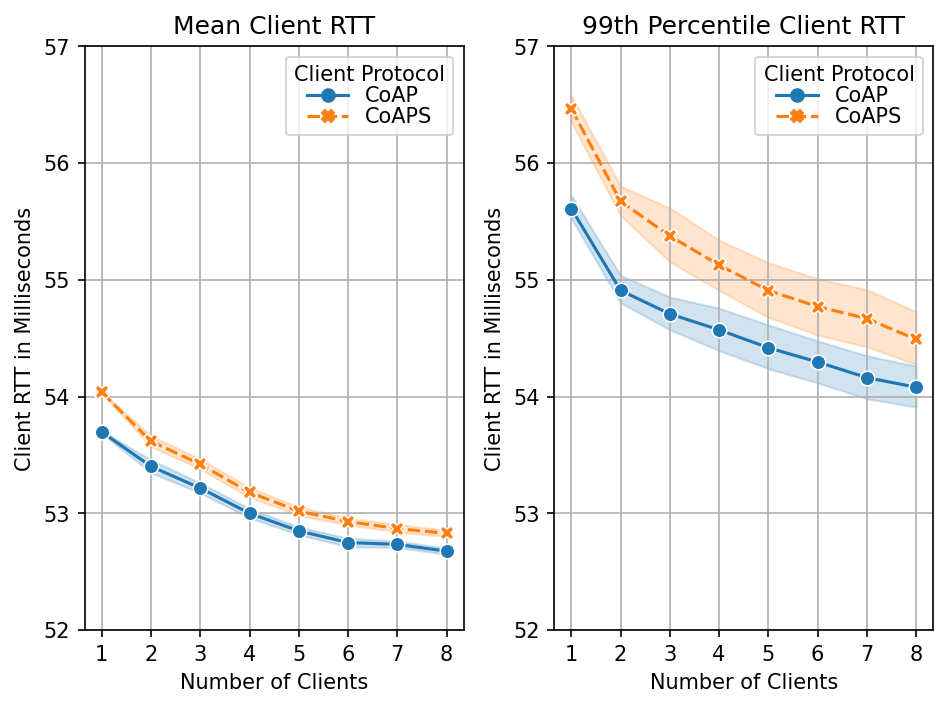

In [12]:
### Plot effect of RTT as a result of increasing number of clients

import matplotlib as mpl
inline_rc = dict(mpl.rcParams)
mpl.rcParams.update(mpl.rcParamsDefault)

plt.rcParams['figure.dpi']  = 150

def get_properties(y):
  if y == "mean_rtt_ms":
    title = "Mean Client RTT"
    ylabel = title + " Milliseconds"
  elif y == "rtt_ms_p99":
    title = "99th Percentile Client RTT"
    ylabel = title + " in Milliseconds"
  else:
    raise Exception()

  ylabel = "Client RTT in Milliseconds"
  
  return {
    "ylabel": ylabel,
    "title": title,
  }

client_rps_df.replace({
  "run_proxy_with_dtls": {
    "coap": "CoAP",
    "dtls": "CoAPS",
  }
}, inplace=True)

df = client_rps_df

ys = ["mean_rtt_ms", "rtt_ms_p99"]
fig, ax = plt.subplots(1, len(ys))
for i, y in enumerate(ys):
  g = sns.lineplot(
    data=df,
    x="num_clients",
    y=y,
    hue="run_proxy_with_dtls",
    style="run_proxy_with_dtls",
    ax=ax[i],
    markers=True,
    markersize=7,
  )

  sns.move_legend(
    g, 
    "upper right", 
    title="Client Protocol", 
    frameon=True, 
    labelspacing=0.05,
    bbox_to_anchor=((1, 1)),
    markerfirst=True,
  )

  props = get_properties(y)
  ax[i].set_xlabel("Number of Clients")
  ax[i].set_ylabel(props["ylabel"])
  ax[i].set_title(props["title"])
  ax[i].grid(True, axis="both")
  ax[i].set_xticks(np.arange(1,9,1))
  ax[i].set_ylim(52, 57)

fig.tight_layout(pad=1)
plt.show()

In [13]:
### At this point, we generate figures for the paper

plt.rcParams['figure.dpi']  = 300
plt.rcParams['savefig.dpi'] = 300

plt.rcParams['font.size']        = '18'
plt.rcParams['lines.linewidth']  = 3
plt.rcParams['lines.markersize'] = 9

client_rps_df.replace({
  "run_proxy_with_dtls": {
    "coap": "CoAP",
    "dtls": "CoAPS",
  }
}, inplace=True)

metric_df.replace({
  "run_proxy_with_dtls": {
    False: "CoAP",
    True : "CoAPS",
  }
}, inplace=True)

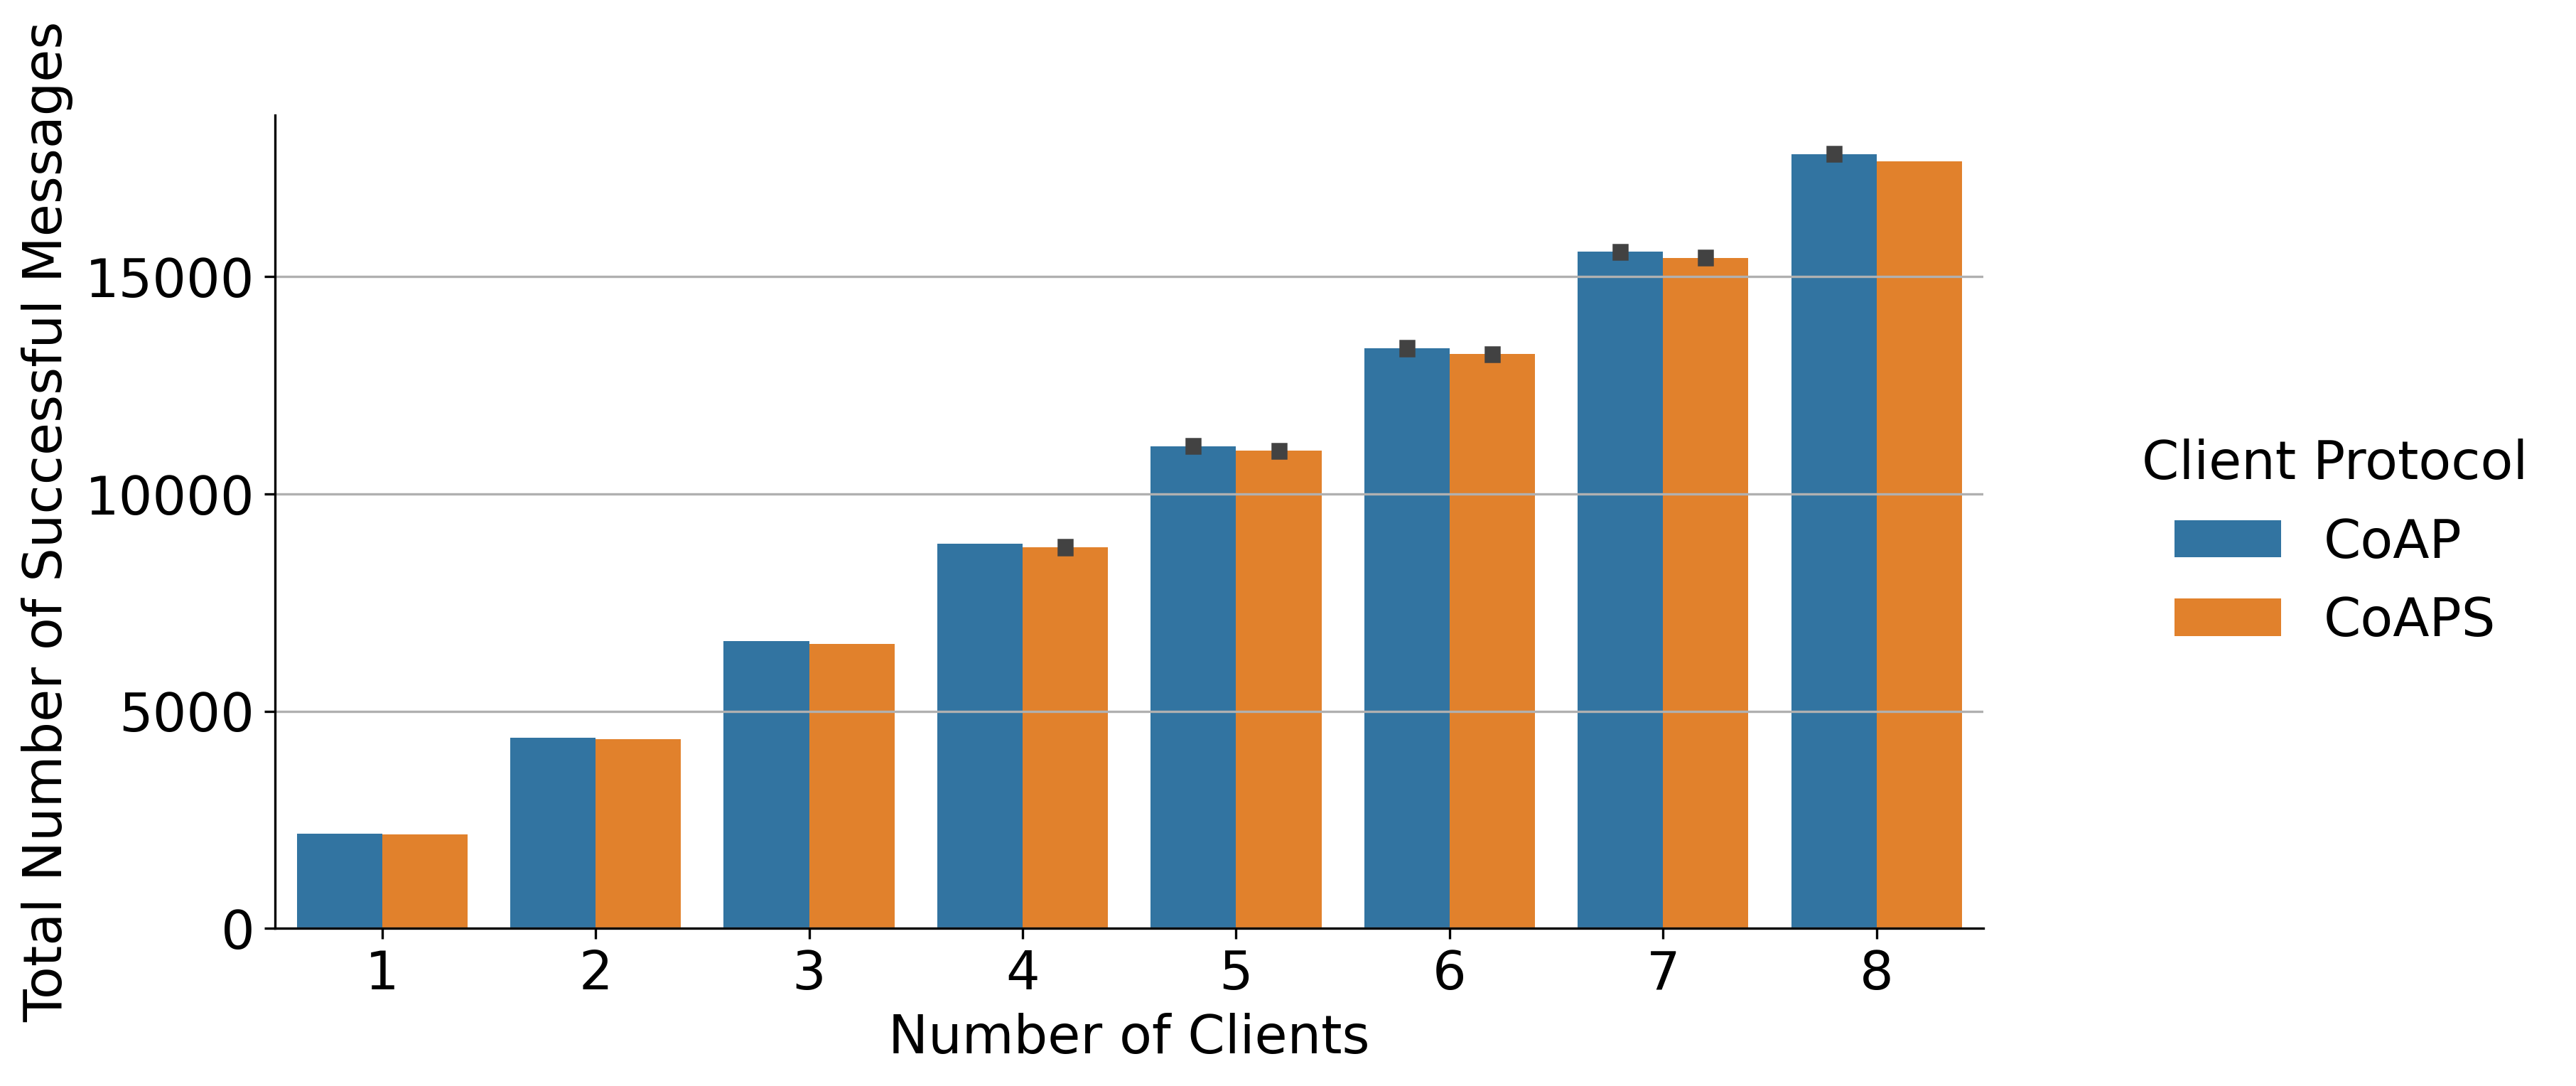

exp_id  \
0   updated_thesis_group_num_clients_1clients_noattacker_coap_https   
1   updated_thesis_group_num_clients_1clients_noattacker_dtls_https   
2   updated_thesis_group_num_clients_2clients_noattacker_coap_https   
3   updated_thesis_group_num_clients_2clients_noattacker_dtls_https   
4   updated_thesis_group_num_clients_3clients_noattacker_coap_https   
5   updated_thesis_group_num_clients_3clients_noattacker_dtls_https   
6   updated_thesis_group_num_clients_4clients_noattacker_coap_https   
7   updated_thesis_group_num_clients_4clients_noattacker_dtls_https   
8   updated_thesis_group_num_clients_5clients_noattacker_coap_https   
9   updated_thesis_group_num_clients_5clients_noattacker_dtls_https   
10  updated_thesis_group_num_clients_6clients_noattacker_coap_https   
11  updated_thesis_group_num_clients_6clients_noattacker_dtls_https   
12  updated_thesis_group_num_clients_7clients_noattacker_coap_https   
13  updated_thesis_group_num_clients_7clients_noattacker_dtls_https   
14  updated_thesis_group_num_clients_8clients_noattacker_coap_https   
15  updated_thesis_group_num_clients_8clients_noattacker_dtls_https   

   run_proxy_with_dtls  num_clients  mean_total_successful_messages  \
0                 CoAP            1                          2185.4   
1                CoAPS            1                          2156.8   
2                 CoAP            2                          4393.8   
3                CoAPS            2                          4348.8   
4                 CoAP            3                          6613.4   
5                CoAPS            3                          6546.8   
6                 CoAP            4                          8854.8   
7                CoAPS            4                          8769.0   
8                 CoAP            5                         11101.8   
9                CoAPS            5                         10994.4   
10                CoAP            6                         13346.0   
11               CoAPS            6                         13215.6   
12                CoAP            7                         15573.6   
13               CoAPS            7                         15434.8   
14                CoAP            8                         17819.4   
15               CoAPS            8                         17654.2   

    mean_successful_messages_per_client  
0                           2185.400000  
1                           2156.800000  
2                           2196.900000  
3                           2174.400000  
4                           2204.466667  
5                           2182.266667  
6                           2213.700000  
7                           2192.250000  
8                           2220.360000  
9                           2198.880000  
10                          2224.333333  
11                          2202.600000  
12                          2224.800000  
13                          2204.971429  
14                          2227.425000  
15                          2206.775000

In [14]:
## Plot total number of successful messages.

client_rps_df["active_time_sec"] = client_rps_df["last_active_time"] - client_rps_df["first_active_time"]

df = (
  client_rps_df
  .groupby(by=["exp_id", "run_proxy_with_dtls", "num_clients", "trial"])
  .agg(
    total_successful_messages=("num_successful_messages", "sum"),
    mean_active_time_sec=("active_time_sec", "mean"),
  )
  .reset_index()
)
df["amortized_successful_rps"] = df["total_successful_messages"] / df["mean_active_time_sec"] / df["num_clients"]

g = sns.catplot(
  data=df,
  kind="bar",
  x="num_clients",
  y="total_successful_messages",
  hue="run_proxy_with_dtls",
  aspect=2,
  # markers=["_", "_"],
  # scatter=True,
  # fit_reg=False,
)

g.set_xlabels("Number of Clients")
g.set_ylabels("Total Number of Successful Messages")
g.legend.set_title("Client Protocol")

plt.grid(True, axis="y")
plt.show()

_df = (
  df
  .groupby(by=["exp_id", "run_proxy_with_dtls", "num_clients"])
  .agg(
    mean_total_successful_messages=("total_successful_messages", "mean"),
  )
  .reset_index()
)
_df["mean_successful_messages_per_client"] = _df["mean_total_successful_messages"] / _df["num_clients"]
_df

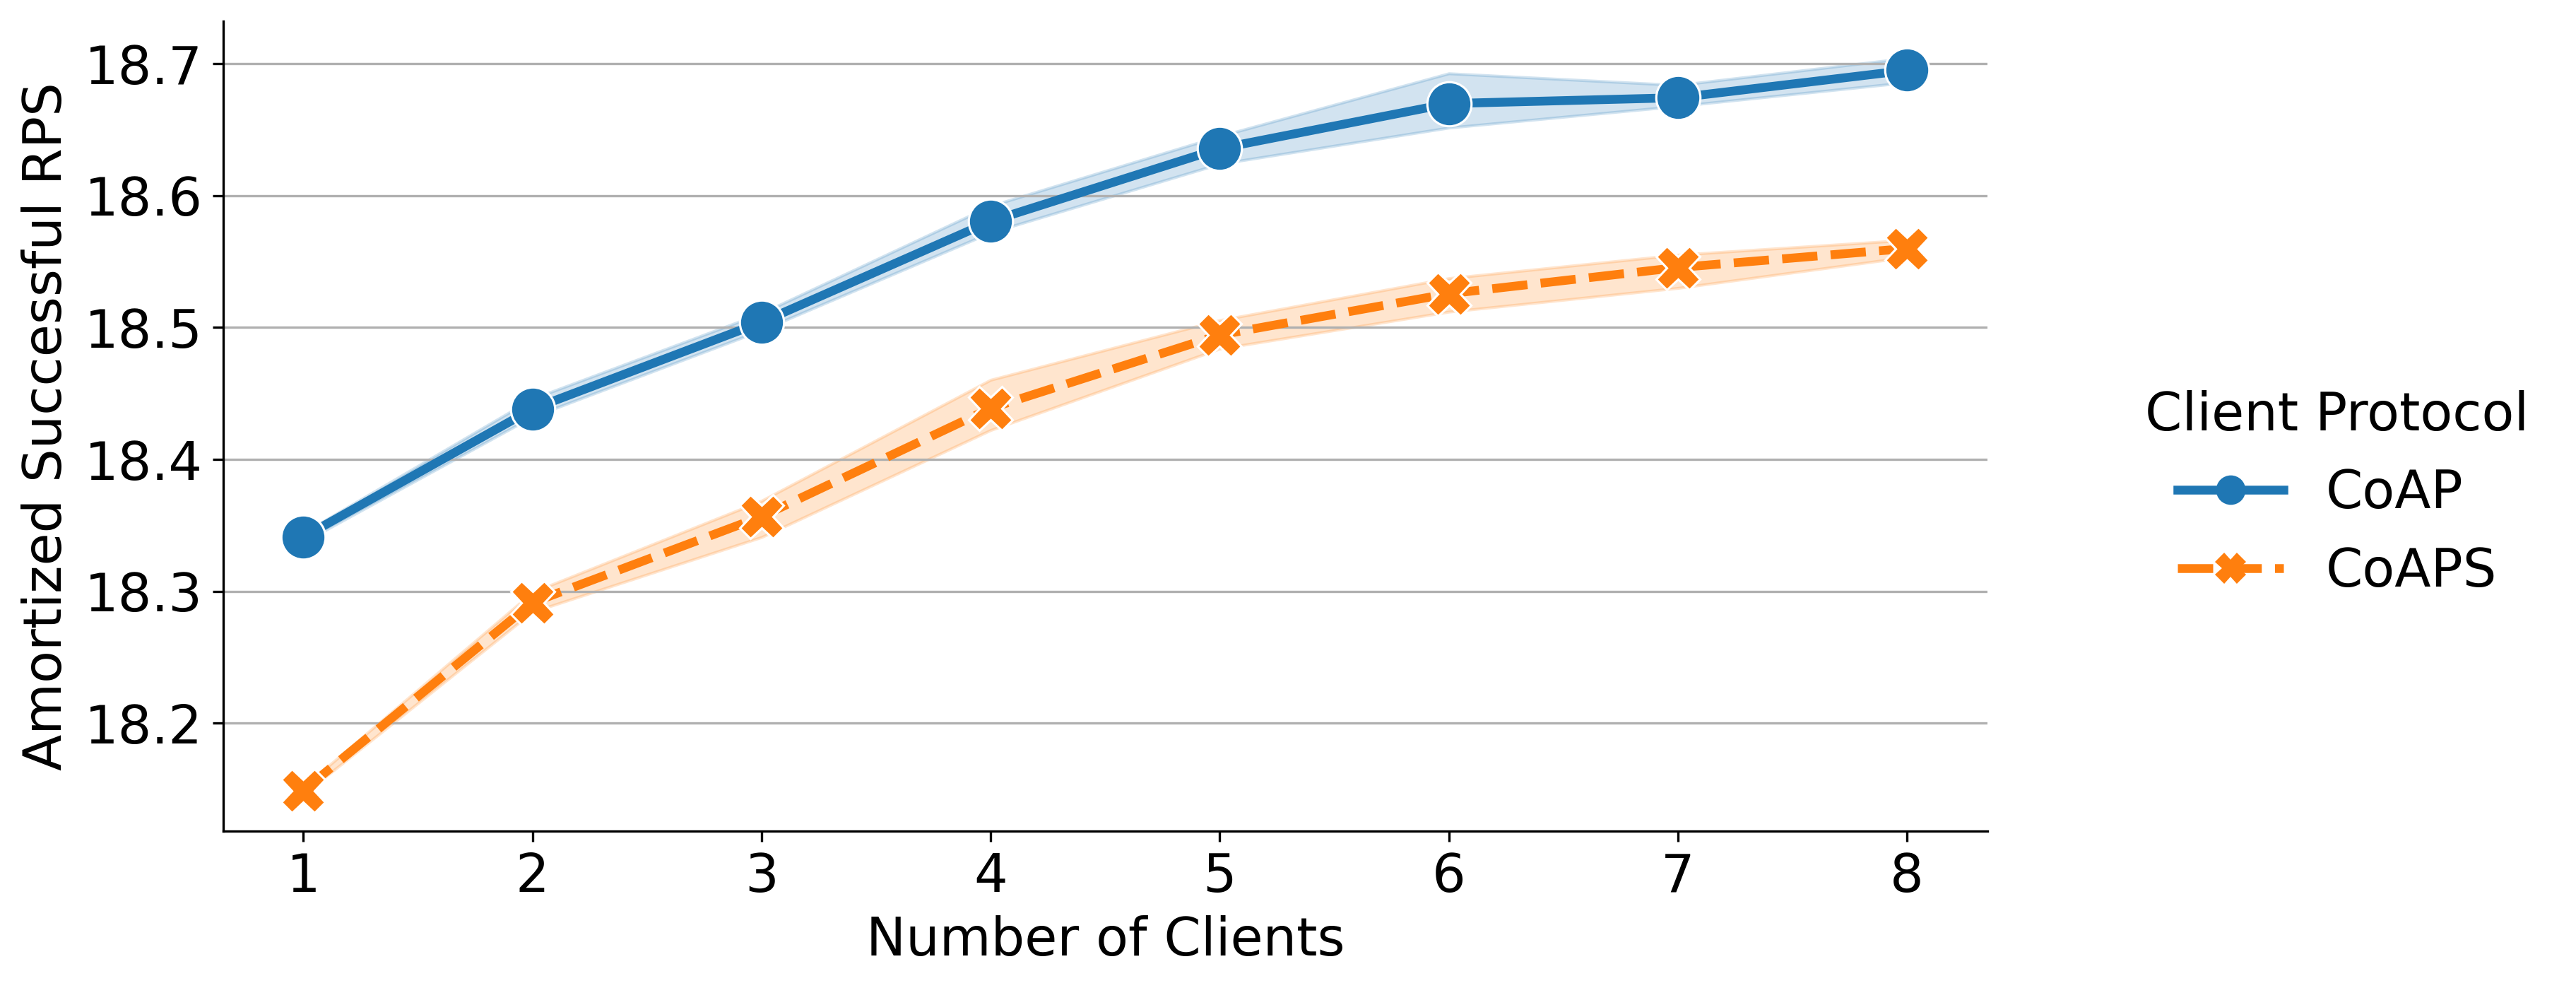

exp_id  \
0   updated_thesis_group_num_clients_1clients_noattacker_coap_https   
1   updated_thesis_group_num_clients_1clients_noattacker_dtls_https   
2   updated_thesis_group_num_clients_2clients_noattacker_coap_https   
3   updated_thesis_group_num_clients_2clients_noattacker_dtls_https   
4   updated_thesis_group_num_clients_3clients_noattacker_coap_https   
5   updated_thesis_group_num_clients_3clients_noattacker_dtls_https   
6   updated_thesis_group_num_clients_4clients_noattacker_coap_https   
7   updated_thesis_group_num_clients_4clients_noattacker_dtls_https   
8   updated_thesis_group_num_clients_5clients_noattacker_coap_https   
9   updated_thesis_group_num_clients_5clients_noattacker_dtls_https   
10  updated_thesis_group_num_clients_6clients_noattacker_coap_https   
11  updated_thesis_group_num_clients_6clients_noattacker_dtls_https   
12  updated_thesis_group_num_clients_7clients_noattacker_coap_https   
13  updated_thesis_group_num_clients_7clients_noattacker_dtls_https   
14  updated_thesis_group_num_clients_8clients_noattacker_coap_https   
15  updated_thesis_group_num_clients_8clients_noattacker_dtls_https   

   run_proxy_with_dtls  num_clients  mean_amortized_successful_rps  \
0                 CoAP            1                      18.341117   
1                CoAPS            1                      18.149020   
2                 CoAP            2                      18.438247   
3                CoAPS            2                      18.291507   
4                 CoAP            3                      18.504038   
5                CoAPS            3                      18.356732   
6                 CoAP            4                      18.580570   
7                CoAPS            4                      18.438860   
8                 CoAP            5                      18.635759   
9                CoAPS            5                      18.494417   
10                CoAP            6                      18.669811   
11               CoAPS            6                      18.525666   
12                CoAP            7                      18.674243   
13               CoAPS            7                      18.545510   
14                CoAP            8                      18.695014   
15               CoAPS            8                      18.559900   

    mean_amortized_rps_messages_per_client  
0                                18.341117  
1                                18.149020  
2                                 9.219124  
3                                 9.145753  
4                                 6.168013  
5                                 6.118911  
6                                 4.645143  
7                                 4.609715  
8                                 3.727152  
9                                 3.698883  
10                                3.111635  
11                                3.087611  
12                                2.667749  
13                                2.649359  
14                                2.336877  
15                                2.319987

In [15]:
g = sns.relplot(
  data=df,
  kind="line",
  x="num_clients",
  y="amortized_successful_rps",
  hue="run_proxy_with_dtls",
  style="run_proxy_with_dtls",
  aspect=2,
  markers=True,
  markersize=15,
)

g.set_xlabels("Number of Clients")
g.set_ylabels("Amortized Successful RPS")
g.legend.set_title("Client Protocol")

plt.grid(True, axis="y")
plt.show()

_df = (
  df
  .groupby(by=["exp_id", "run_proxy_with_dtls", "num_clients"])
  .agg(
    mean_amortized_successful_rps=("amortized_successful_rps", "mean"),
  )
  .reset_index()
)
_df["mean_amortized_rps_messages_per_client"] = _df["mean_amortized_successful_rps"] / _df["num_clients"]
_df

In [16]:
## Plot retransmissions as a function of clients and protocol.

df = (
  client_rps_df.groupby(by=["exp_id", "trial", "num_clients", "run_proxy_with_dtls"])
  .agg(
    total_num_retransmissions=("total_num_retransmissions", "sum")
  )
  .reset_index()
)

# Makes no sense to graph since there are no retransmissions.
# g = sns.catplot(
#   data=df,
#   kind="bar",
#   x="num_clients",
#   y="total_num_retransmissions",
#   hue="run_proxy_with_dtls",
# )
# plt.show()

df[df["total_num_retransmissions"] > 0]

Empty DataFrame
Columns: [exp_id, trial, num_clients, run_proxy_with_dtls, total_num_retransmissions]
Index: []

In [17]:
%%time

## Determine transaction success rate

# Combine send and receive events for clients.
client_events_df = client_sends_df.merge(client_recvs_df, on=["exp_id", "trial", "observer_id", "message_marker"], how="left")
client_events_df.rename(columns={
  "observe_timestamp_x": "send_timestamp",
  "observe_timestamp_y": "recv_timestamp",
}, inplace=True)
client_events_df["rtt_ms"] = 1e3 * (client_events_df["recv_timestamp"] - client_events_df["send_timestamp"])

# Edge case: sometimes clients will not receive a
# response back at the end of the experiment, so
# we ignore those messages, if any.
grouped_last_nan_indicies_to_remove = (
  client_events_df.reset_index()[
    client_events_df["recv_timestamp"].isna()
  ]
  .groupby(by=["exp_id", "trial", "observer_id", "message_marker"])
  .agg(
    last_nan_recv_timestamp=("recv_timestamp", "last"),
    original_index=("index", "last"),
  )
  .reset_index()
  ["original_index"]
  .unique()
)
client_events_df.drop(index=grouped_last_nan_indicies_to_remove, inplace=True)
client_events_df.reset_index(inplace=True)
client_events_df.drop(columns=["index"], inplace=True)

# Produce the total number of messages, and number 
# messages with a matching successful response.
grouped_client_events_df = (
  client_events_df
  .groupby(["exp_id", "trial", "observer_id"])
  .agg(
    unique_message_markers=("message_marker", "nunique"),
    num_successful_messages=("successful_message", "sum"),
  )
  .reset_index()
)

# Now compute the successful transaction rate.
grouped_client_events_df["transaction_success_rate"] = 100 * grouped_client_events_df["num_successful_messages"] / grouped_client_events_df["unique_message_markers"]

grouped_client_events_df = (
  grouped_client_events_df
  .merge(exp_df, on="exp_id", how="left")
  .replace({
    "run_proxy_with_dtls": {
      True : "CoAPS",
      False: "CoAP",
    },
  })
)

grouped_client_events_df

CPU times: user 2.67 s, sys: 483 ms, total: 3.15 s
Wall time: 3.15 s


exp_id  trial  \
0    updated_thesis_group_num_clients_1clients_noattacker_coap_https      1   
1    updated_thesis_group_num_clients_1clients_noattacker_coap_https      2   
2    updated_thesis_group_num_clients_1clients_noattacker_coap_https      3   
3    updated_thesis_group_num_clients_1clients_noattacker_coap_https      4   
4    updated_thesis_group_num_clients_1clients_noattacker_coap_https      5   
..                                                               ...    ...   
355  updated_thesis_group_num_clients_8clients_noattacker_dtls_https      5   
356  updated_thesis_group_num_clients_8clients_noattacker_dtls_https      5   
357  updated_thesis_group_num_clients_8clients_noattacker_dtls_https      5   
358  updated_thesis_group_num_clients_8clients_noattacker_dtls_https      5   
359  updated_thesis_group_num_clients_8clients_noattacker_dtls_https      5   

    observer_id  unique_message_markers num_successful_messages  \
0       client1                    2185                    2185   
1       client1                    2186                    2186   
2       client1                    2185                    2185   
3       client1                    2186                    2186   
4       client1                    2185                    2185   
..          ...                     ...                     ...   
355     client4                    2209                    2209   
356     client5                    2209                    2209   
357     client6                    2211                    2211   
358     client7                    2211                    2211   
359     client8                    2212                    2212   

    transaction_success_rate attacker_rate  server_connections  \
0                      100.0         0mbps                 256   
1                      100.0         0mbps                 256   
2                      100.0         0mbps                 256   
3                      100.0         0mbps                 256   
4                      100.0         0mbps                 256   
..                       ...           ...                 ...   
355                    100.0         0mbps                 256   
356                    100.0         0mbps                 256   
357                    100.0         0mbps                 256   
358                    100.0         0mbps                 256   
359                    100.0         0mbps                 256   

     max_keep_alive_requests  num_clients  ...  \
0                          0            1  ...   
1                          0            1  ...   
2                          0            1  ...   
3                          0            1  ...   
4                          0            1  ...   
..                       ...          ...  ...   
355                        0            8  ...   
356                        0            8  ...   
357                        0            8  ...   
358                        0            8  ...   
359                        0            8  ...   

                                topology_name  num_proxy_connections  \
0    thesis_cloud_proxy_and_internet_attacker                     50   
1    thesis_cloud_proxy_and_internet_attacker                     50   
2    thesis_cloud_proxy_and_internet_attacker                     50   
3    thesis_cloud_proxy_and_internet_attacker                     50   
4    thesis_cloud_proxy_and_internet_attacker                     50   
..                                        ...                    ...   
355  thesis_cloud_proxy_and_internet_attacker                     50   
356  thesis_cloud_proxy_and_internet_attacker                     50   
357  thesis_cloud_proxy_and_internet_attacker                     50   
358  thesis_cloud_proxy_and_internet_attacker                     50   
359  thesis_cloud_proxy_and_internet_attacker                     50   

     request_timeout  max_retries  keep_alive_dur

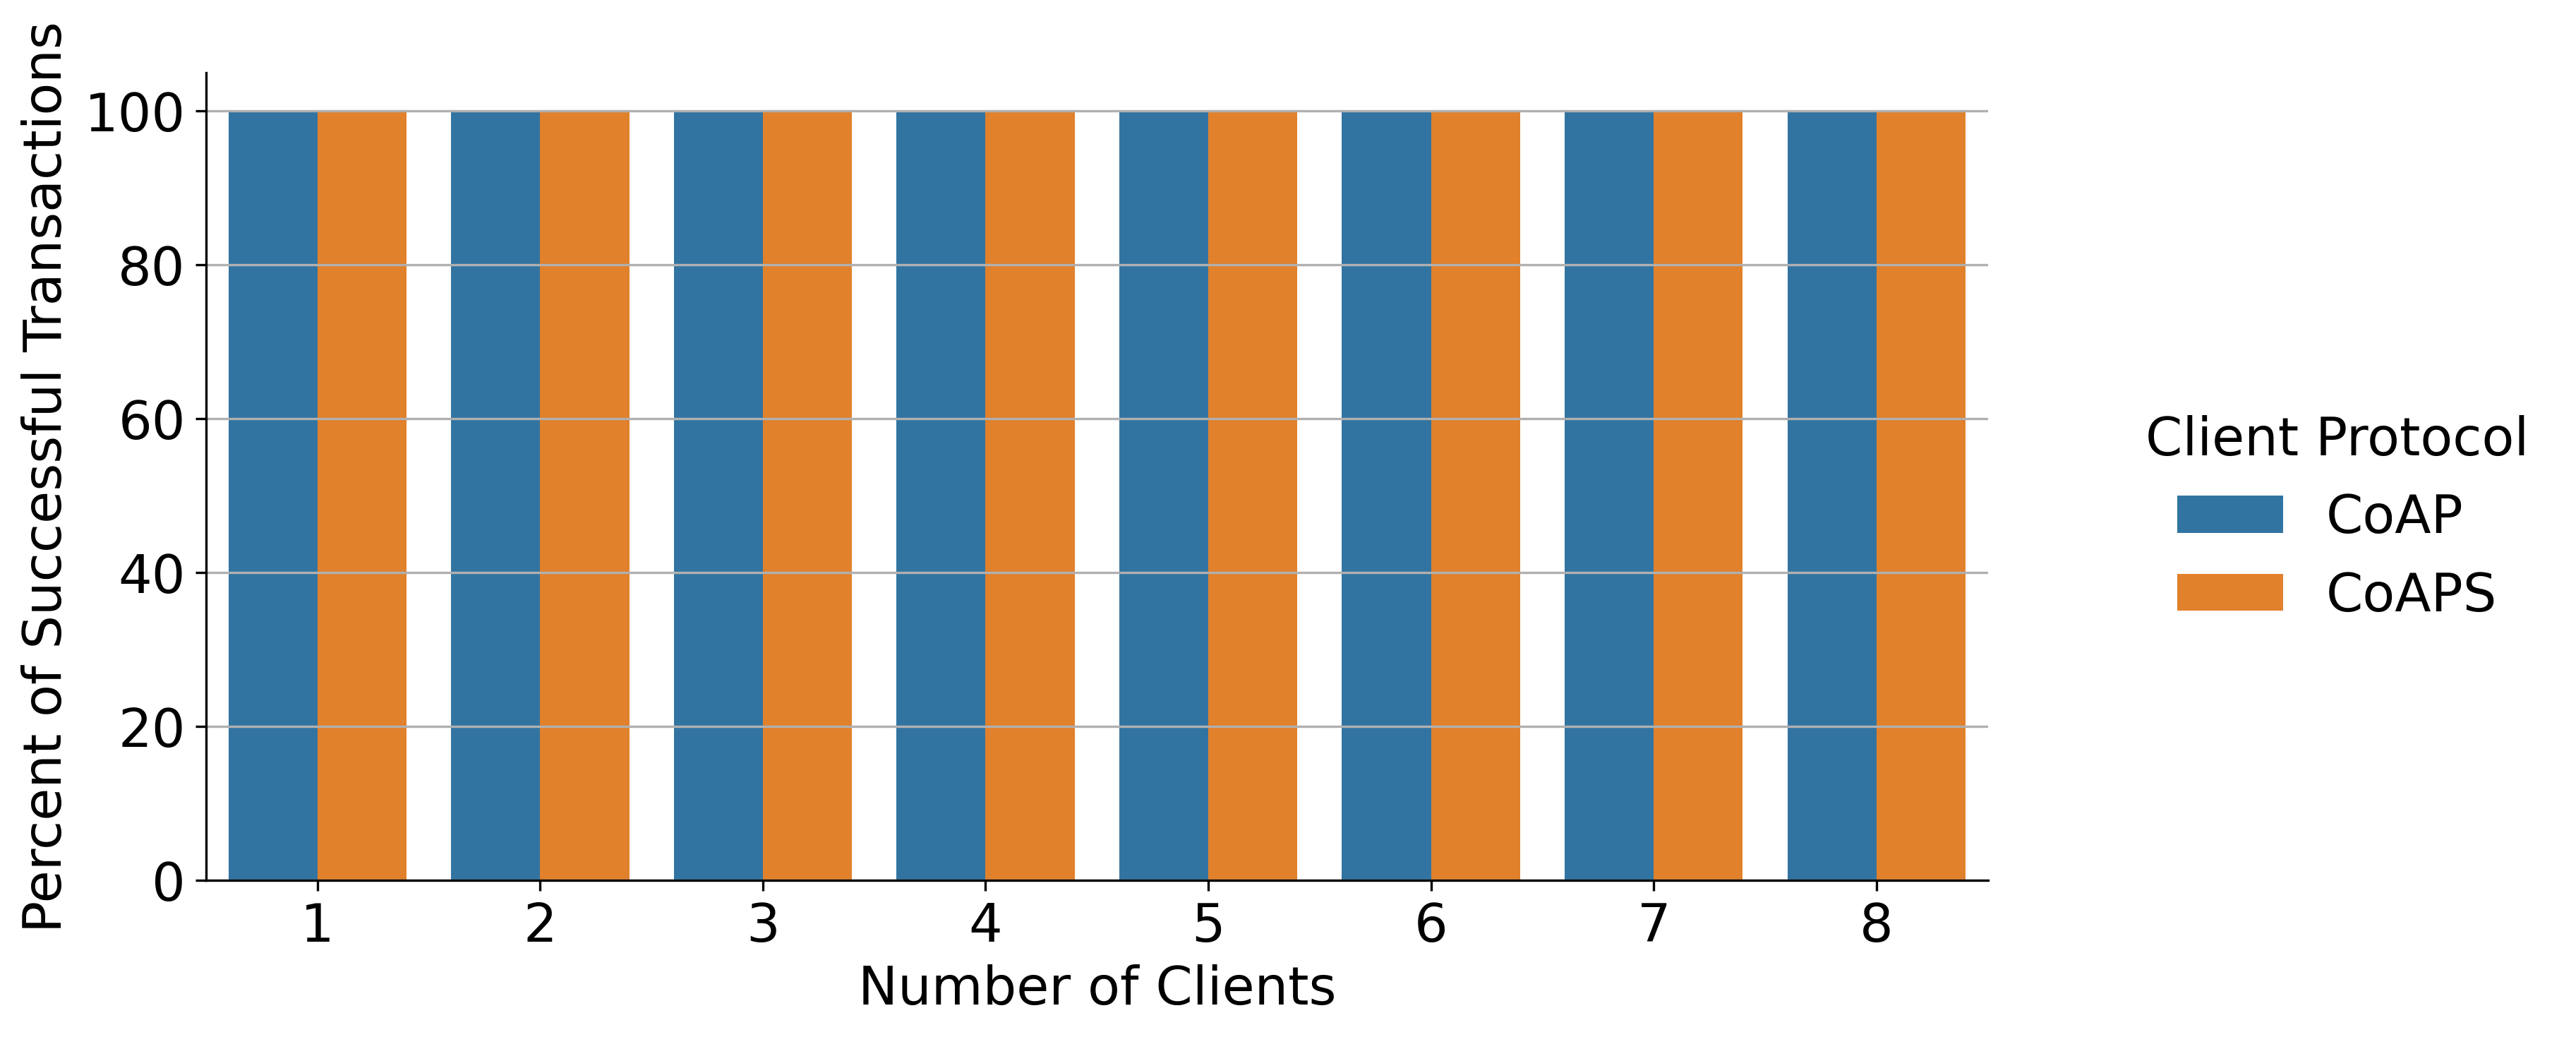

Empty DataFrame
Columns: [exp_id, trial, observer_id, unique_message_markers, num_successful_messages, transaction_success_rate, attacker_rate, server_connections, max_keep_alive_requests, num_clients, num_trials, origin_server_duration, attacker_duration, receiver_duration, proxy_duration, client_duration, attacker_start_lag_duration, topology_name, num_proxy_connections, request_timeout, max_retries, keep_alive_duration, request_retry_interval, reuse_connections, run_proxy_with_dtls, run_proxy_with_https, run_attacker]
Index: []

[0 rows x 27 columns]

In [18]:
df = grouped_client_events_df

g = sns.catplot(
  data=df,
  kind="bar",
  x="num_clients",
  y="transaction_success_rate",
  hue="run_proxy_with_dtls",
  ci="sd",
  aspect=2,
)

g.set_xlabels("Number of Clients")
g.set_ylabels("Percent of Successful Transactions")
g.legend.set_title("Client Protocol")

plt.grid(True, axis="y")
plt.show()

grouped_client_events_df[
  grouped_client_events_df["transaction_success_rate"] < 100
]

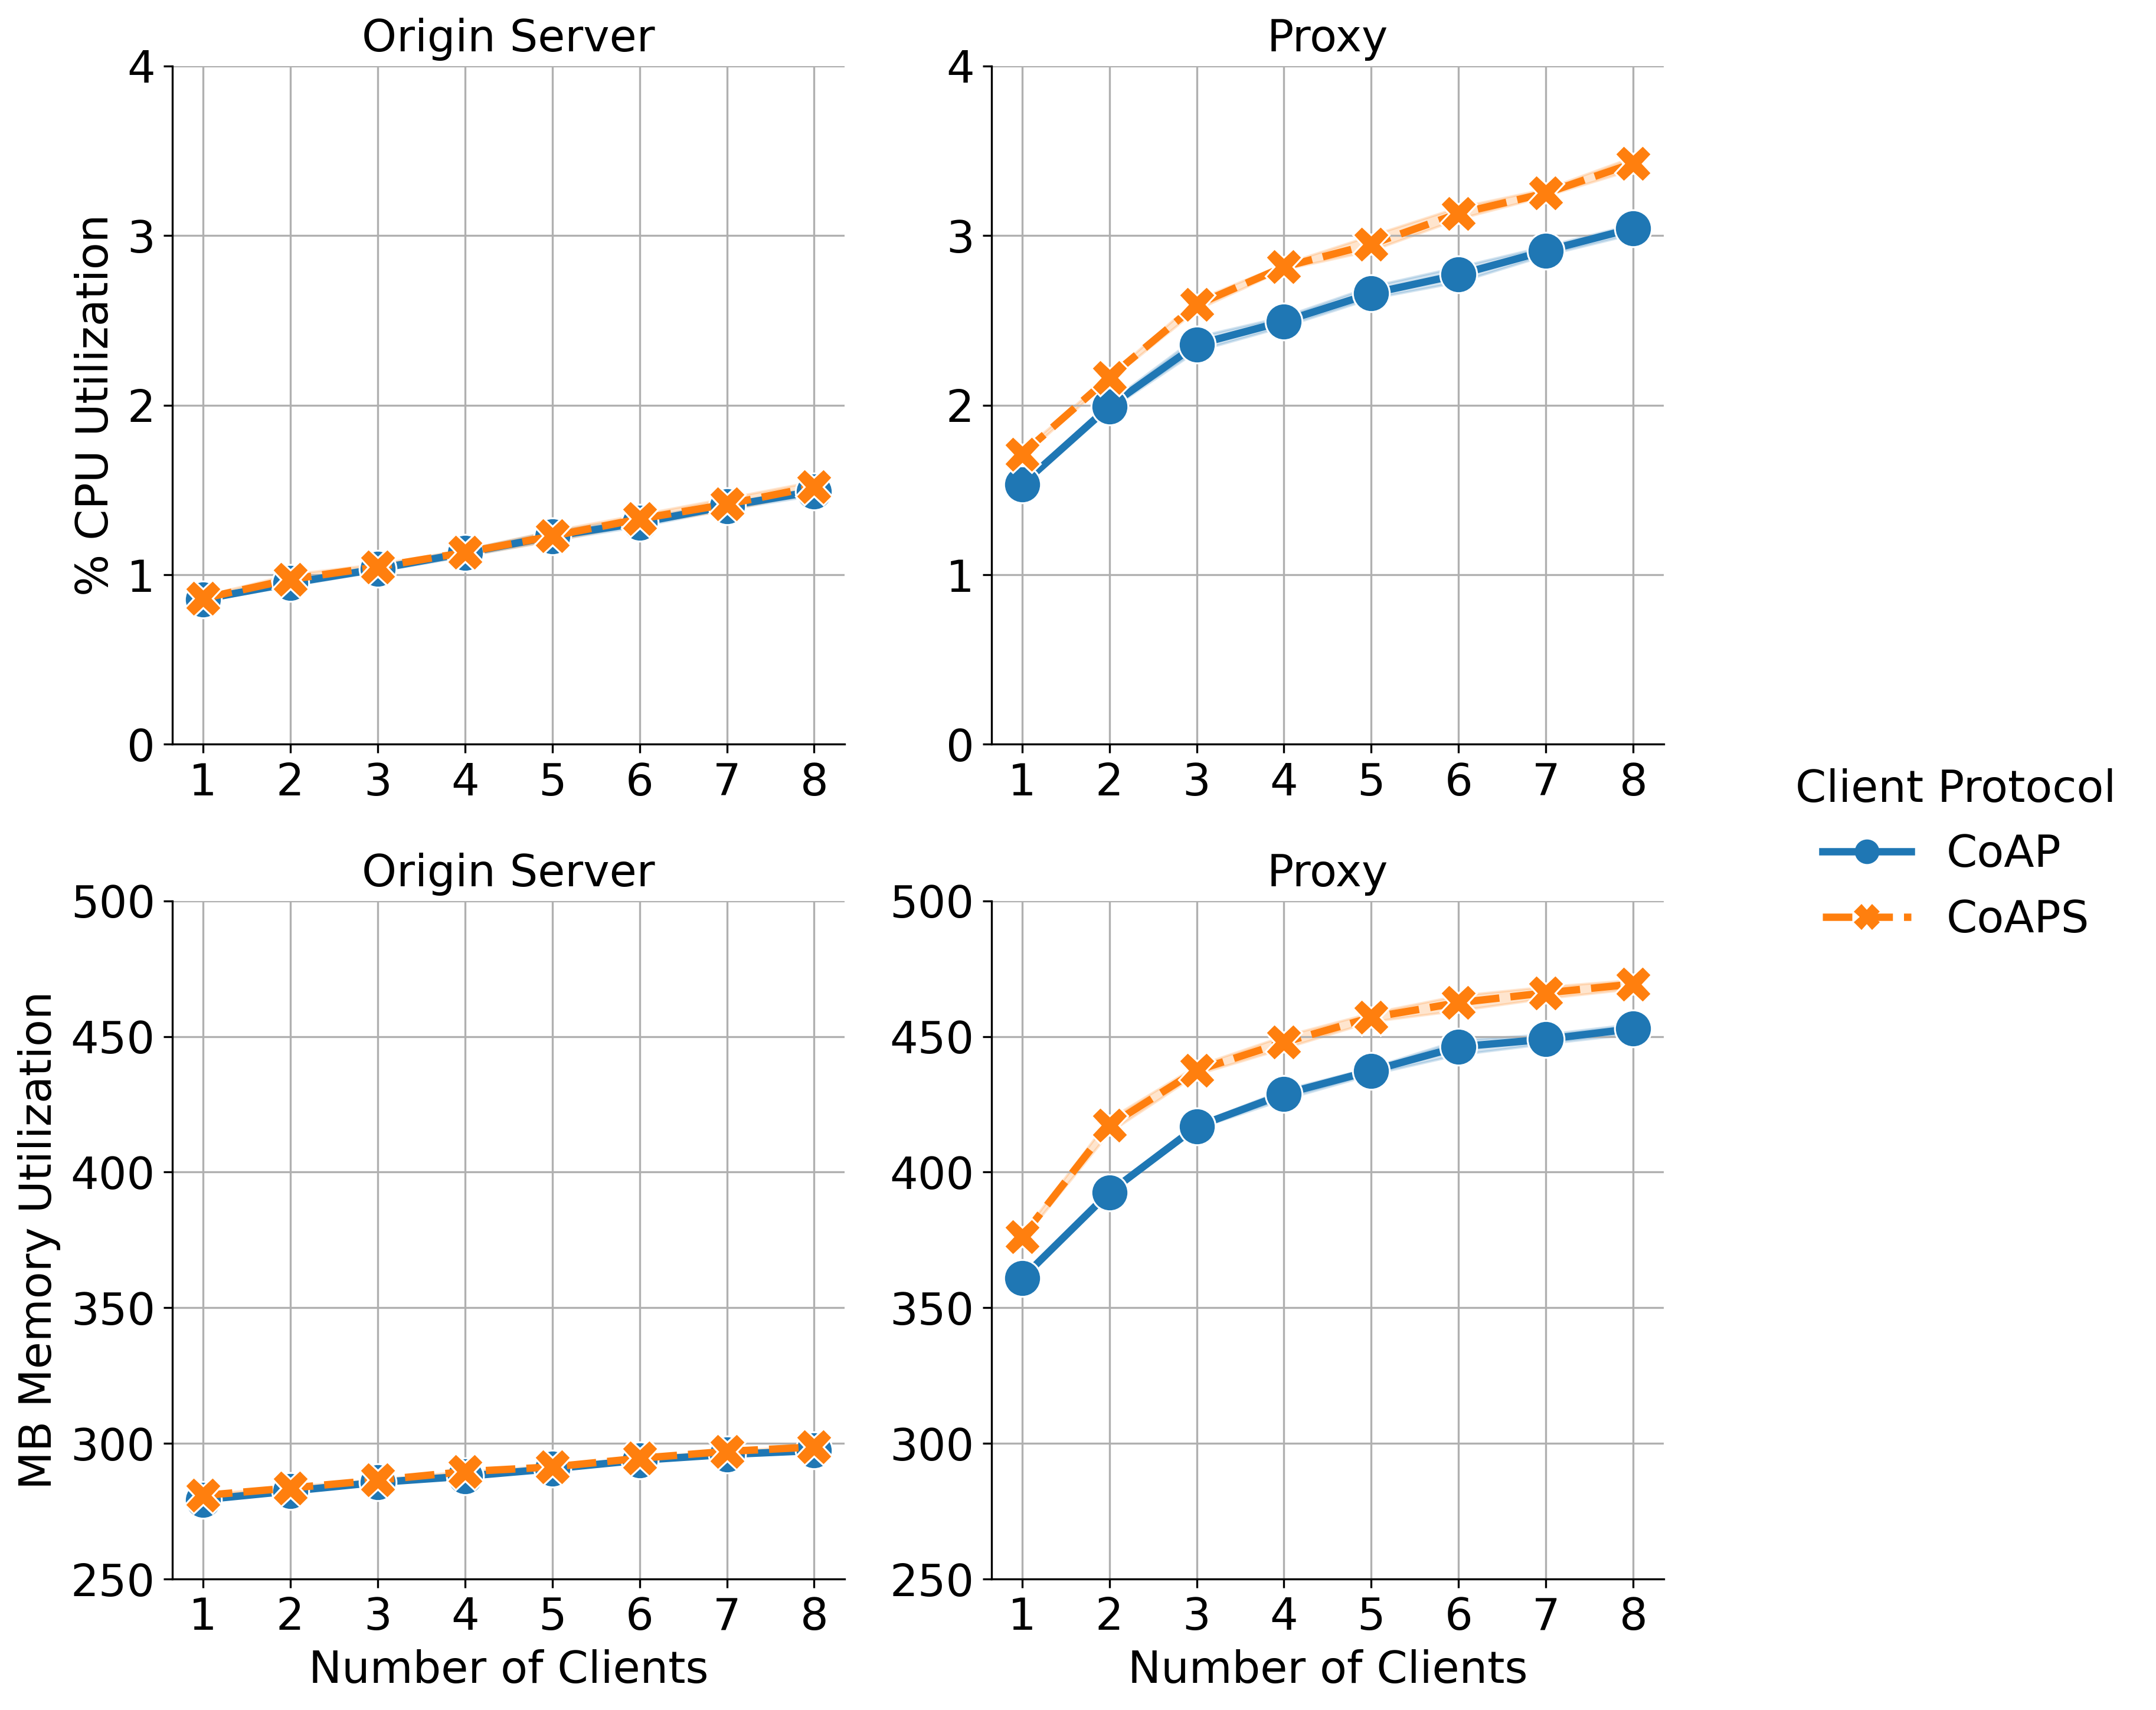

CPU times: user 4.07 s, sys: 402 ms, total: 4.48 s
Wall time: 3.93 s


exp_id  trial  \
0    updated_thesis_group_num_clients_1clients_noattacker_coap_https      1   
1    updated_thesis_group_num_clients_1clients_noattacker_coap_https      1   
2    updated_thesis_group_num_clients_1clients_noattacker_coap_https      1   
3    updated_thesis_group_num_clients_1clients_noattacker_coap_https      1   
4    updated_thesis_group_num_clients_1clients_noattacker_coap_https      2   
..                                                               ...    ...   
315  updated_thesis_group_num_clients_8clients_noattacker_dtls_https      4   
316  updated_thesis_group_num_clients_8clients_noattacker_dtls_https      5   
317  updated_thesis_group_num_clients_8clients_noattacker_dtls_https      5   
318  updated_thesis_group_num_clients_8clients_noattacker_dtls_https      5   
319  updated_thesis_group_num_clients_8clients_noattacker_dtls_https      5   

       observer_id            metric_type   avg_value  min_value  max_value  \
0    Origin Server      % CPU Utilization    0.866429        0.4       10.5   
1            Proxy      % CPU Utilization    1.521429        0.4       20.0   
2    Origin Server  MB Memory Utilization  278.801980      266.0      280.0   
3            Proxy  MB Memory Utilization  360.671074      245.0      397.0   
4    Origin Server      % CPU Utilization    0.862143        0.4        9.0   
..             ...                    ...         ...        ...        ...   
315          Proxy  MB Memory Utilization  470.439669      249.0      505.0   
316  Origin Server      % CPU Utilization    1.566429        0.4        9.3   
317          Proxy      % CPU Utilization    3.360714        0.4       27.4   
318  Origin Server  MB Memory Utilization  298.502479      285.0      300.0   
319          Proxy  MB Memory Utilization  470.257851      250.0      505.0   

    attacker_rate  server_connections  max_keep_alive_requests  ...  \
0           0mbps                 256                        0  ...   
1           0mbps                 256                        0  ...   
2           0mbps                 256                        0  ...   
3           0mbps                 256                        0  ...   
4           0mbps                 256                        0  ...   
..            ...                 ...                      ...  ...   
315         0mbps                 256                        0  ...   
316         0mbps                 256                        0  ...   
317         0mbps                 256                        0  ...   
318         0mbps                 256                        0  ...   
319         0mbps                 256                        0  ...   

                                topology_name  num_proxy_connections  \
0    thesis_cloud_proxy_and_internet_attacker                     50   
1    thesis_cloud_proxy_and_internet_attacker                     50   
2    thesis_cloud_proxy_and_internet_attacker                     50   
3    thesis_cloud_proxy_and_internet_attacker                     50   
4    thesis_cloud_proxy_and_internet_attacker                     50   
..                                        ...                    ...   
315  thesis_cloud_proxy_and_internet_attacker                     50   
316  thesis_cloud_proxy_and_internet_attacker                     50   
317  thesis_cloud_proxy_and_internet_attacker                     50   
318  thesis_cloud_proxy_and_internet_attacker                     50   
319  thesis_cloud_proxy_and_internet_attacker                     50   

     request_timeout  max_retries  keep_alive_duration  \
0                  5            4                  150   
1                  5            4                  150   
2                  5            4                  150   
3                  5            4                  150   
4                  5            4                  150   
..               ...          ...                  ...   
315                5            4       

In [19]:
%%time

## Measure proxy and server metrics.

df = (
  metric_df.replace({
    "metric_type": {
      "cpu_utilization": "% CPU Utilization",
      "memory_utilization": "MB Memory Utilization",
    },
    "observer_id": {
      "proxy": "Proxy",
      "originserver": "Origin Server",
    },
  })
)

g = sns.relplot(
  data=df,
  kind="line",
  x="num_clients",
  y="avg_value",
  col="observer_id",
  row="metric_type",
  hue="run_proxy_with_dtls",
  style="run_proxy_with_dtls",
  markers=True,
  markersize=15,
  facet_kws={
    "sharey": False,
    "sharex": False,
  },
)

g.set_titles(
  template="{col_name}",
  col_template="{col_name}",
  row_template="{row_name}",
)
g.set_xlabels("Number of Clients")
g.set_ylabels("Average Metric Value")
g.legend.set_title("Client Protocol")
g.set(xticks=np.arange(1,9,1))

g.axes[0,0].set_ylabel("% CPU Utilization")
g.axes[0,1].set_ylabel("")
g.axes[0,0].set_ylim(0,4)
g.axes[0,1].set_ylim(0,4)

g.axes[1,0].set_ylabel("MB Memory Utilization")
g.axes[1,1].set_ylabel("")
g.axes[1,0].set_ylim(250, 500)
g.axes[1,1].set_ylim(250, 500)

g.axes[0,0].grid(True, axis="both")
g.axes[0,1].grid(True, axis="both")
g.axes[1,0].grid(True, axis="both")
g.axes[1,1].grid(True, axis="both")

fig.tight_layout(pad=0.5)

plt.show()

df

In [20]:
%%time

## Measure proxy and server connection management.
##
## We currently do not insert connection events to
## the database, so we have to read from the processed
## connection files.

ALL_EXPERIMENTS_DATA_HOME = "/home/ubuntu/dos-californium/deter/expdata/real/final"

def read_exp_trial_node_connections(exp_id):
  """
  Read all processed connection dumps in an experiment `exp_id`.
  """
  experiment_dir = os.path.join(ALL_EXPERIMENTS_DATA_HOME, exp_id)

  df = (
    pl
    .scan_parquet(
      f"{experiment_dir}/*/{exp_id}.connections.parquet"
    )
  )
  lazy_dfs.append(df)

lazy_dfs = list()
for exp_id in exp_df["exp_id"].unique():
  read_exp_trial_node_connections(exp_id)

connections_df = (
  pl
  .concat(lazy_dfs)

  # Filter for proxy's view of syn-acks or fin-acks coming from server
  .filter(
    (pl.col("observer_id") == "proxy")
    & ((pl.col("is_syn") == 1) | (pl.col("is_fin") == 1))
    & (pl.col("info").str.contains(", ACK]"))
    & (pl.col("src_port") == 443)
  )
  # Group by experiment, trial, and observer, then accummulate
  # syn-acks and fin-acks in a list, along with their corresponding
  # timestamps of occurrence for each group.
  .groupby(
    by=["exp_id", "trial", "observer_id"],
    maintain_order=True
  )
  .agg([
    pl.col("timestamp").alias("timestamp"),
    pl.col("is_syn").cumsum().alias("cum_syn"),
    pl.col("is_fin").cumsum().alias("cum_fin"),
  ])
  # Explode the cumulative syns and fins, and their times, then
  # subtract them to get a view of how many open connections there
  # are in the experiment as a function of time
  .explode(columns=["timestamp", "cum_syn", "cum_fin"])
  .with_columns([
    (pl.col("cum_syn") - pl.col("cum_fin")).alias("open_connections")
  ])

  # And finally convert to pandas for plotting.
  .collect()
  .to_pandas()
)

# This method of counting does not include the original 0 connections
# at time 0 for each node in each trial -- so we add that manually.
records = list()
for e in connections_df["exp_id"].unique():
  for t in connections_df["trial"].unique():
    for o in connections_df["observer_id"].unique():
      records.append({
        "exp_id"          : e,
        "trial"           : t,
        "observer_id"     : o,
        "timestamp"       : 0.0,
        "cum_syn"         : 0,
        "cum_fin"         : 0,
        "open_connections": 0,
      })
connections_df = (
  pd.concat(
    [connections_df, pd.DataFrame.from_records(records)]
  )
  .sort_values(by=["exp_id", "trial", "observer_id", "timestamp"])
)

# This method also does not include a connection count at the last time
# the proxy is meant to be active -- so we fill that value in based on the
# last value.
last_connection_df = (
  connections_df
  .groupby(by=["exp_id", "trial", "observer_id"], sort=True)
  .agg(
    max_timestamp=("timestamp", "max"),
    last_timestamp=("timestamp", "last"),
    max_open_connections=("open_connections", "max"),
    last_open_connections=("open_connections", "last"),
    last_cum_syn=("cum_syn", "last"),
    last_cum_fin=("cum_fin", "last"),
  )
  .reset_index()
)
assert last_connection_df["max_timestamp"].equals(last_connection_df["last_timestamp"])
assert last_connection_df["max_open_connections"].equals(last_connection_df["last_open_connections"])
records = list()
for r in last_connection_df.to_dict(orient="records"):
  records.append({
    "exp_id"          : r["exp_id"],
    "trial"           : r["trial"],
    "observer_id"     : r["observer_id"],
    "timestamp"       : 140,
    "cum_syn"         : r["last_cum_syn"],
    "cum_fin"         : r["last_cum_fin"],
    "open_connections": r["last_open_connections"],
  })
connections_df = (
  pd.concat(
    [connections_df, pd.DataFrame.from_records(records)]
  )
  .sort_values(by=["exp_id", "trial", "observer_id", "timestamp"])
)

connections_df = (
  connections_df
  .merge(exp_df, on="exp_id", how="left")
  .replace({
    "run_proxy_with_dtls": {
      True : "CoAPS",
      False: "CoAP",
    },
  })
)

connections_df

CPU times: user 6.13 s, sys: 32.6 s, total: 38.8 s
Wall time: 2.55 s


exp_id  trial  \
0    updated_thesis_group_num_clients_1clients_noattacker_coap_https      1   
1    updated_thesis_group_num_clients_1clients_noattacker_coap_https      1   
2    updated_thesis_group_num_clients_1clients_noattacker_coap_https      1   
3    updated_thesis_group_num_clients_1clients_noattacker_coap_https      2   
4    updated_thesis_group_num_clients_1clients_noattacker_coap_https      2   
..                                                               ...    ...   
514  updated_thesis_group_num_clients_8clients_noattacker_dtls_https      5   
515  updated_thesis_group_num_clients_8clients_noattacker_dtls_https      5   
516  updated_thesis_group_num_clients_8clients_noattacker_dtls_https      5   
517  updated_thesis_group_num_clients_8clients_noattacker_dtls_https      5   
518  updated_thesis_group_num_clients_8clients_noattacker_dtls_https      5   

    observer_id   timestamp  cum_syn  cum_fin  open_connections attacker_rate  \
0         proxy    0.000000        0        0                 0         0mbps   
1         proxy    0.067785        1        0                 1         0mbps   
2         proxy  140.000000        1        0                 1         0mbps   
3         proxy    0.000000        0        0                 0         0mbps   
4         proxy    0.058544        1        0                 1         0mbps   
..          ...         ...      ...      ...               ...           ...   
514       proxy    7.365021        5        0                 5         0mbps   
515       proxy    7.909375        6        0                 6         0mbps   
516       proxy   26.272243        7        0                 7         0mbps   
517       proxy   26.272244        8        0                 8         0mbps   
518       proxy  140.000000        8        0                 8         0mbps   

     server_connections  max_keep_alive_requests  ...  \
0                   256                        0  ...   
1                   256                        0  ...   
2                   256                        0  ...   
3                   256                        0  ...   
4                   256                        0  ...   
..                  ...                      ...  ...   
514                 256                        0  ...   
515                 256                        0  ...   
516                 256                        0  ...   
517                 256                        0  ...   
518                 256                        0  ...   

                                topology_name  num_proxy_connections  \
0    thesis_cloud_proxy_and_internet_attacker                     50   
1    thesis_cloud_proxy_and_internet_attacker                     50   
2    thesis_cloud_proxy_and_internet_attacker                     50   
3    thesis_cloud_proxy_and_internet_attacker                     50   
4    thesis_cloud_proxy_and_internet_attacker                     50   
..                                        ...                    ...   
514  thesis_cloud_proxy_and_internet_attacker                     50   
515  thesis_cloud_proxy_and_internet_attacker                     50   
516  thesis_cloud_proxy_and_internet_attacker                     50   
517  thesis_cloud_proxy_and_internet_attacker                     50   
518  thesis_cloud_proxy_and_internet_attacker                     50   

     request_timeout  max_retries  keep_alive_duration  \
0                  5            4                  150   
1                  5            4                  150   
2                  5            4                  150   
3                  5            4                  150   
4                  5            4                  150   
..               ...          ...                  ...   
514                5            4                  150   
515                5            4                  150   
516                5            4                  150   
517       

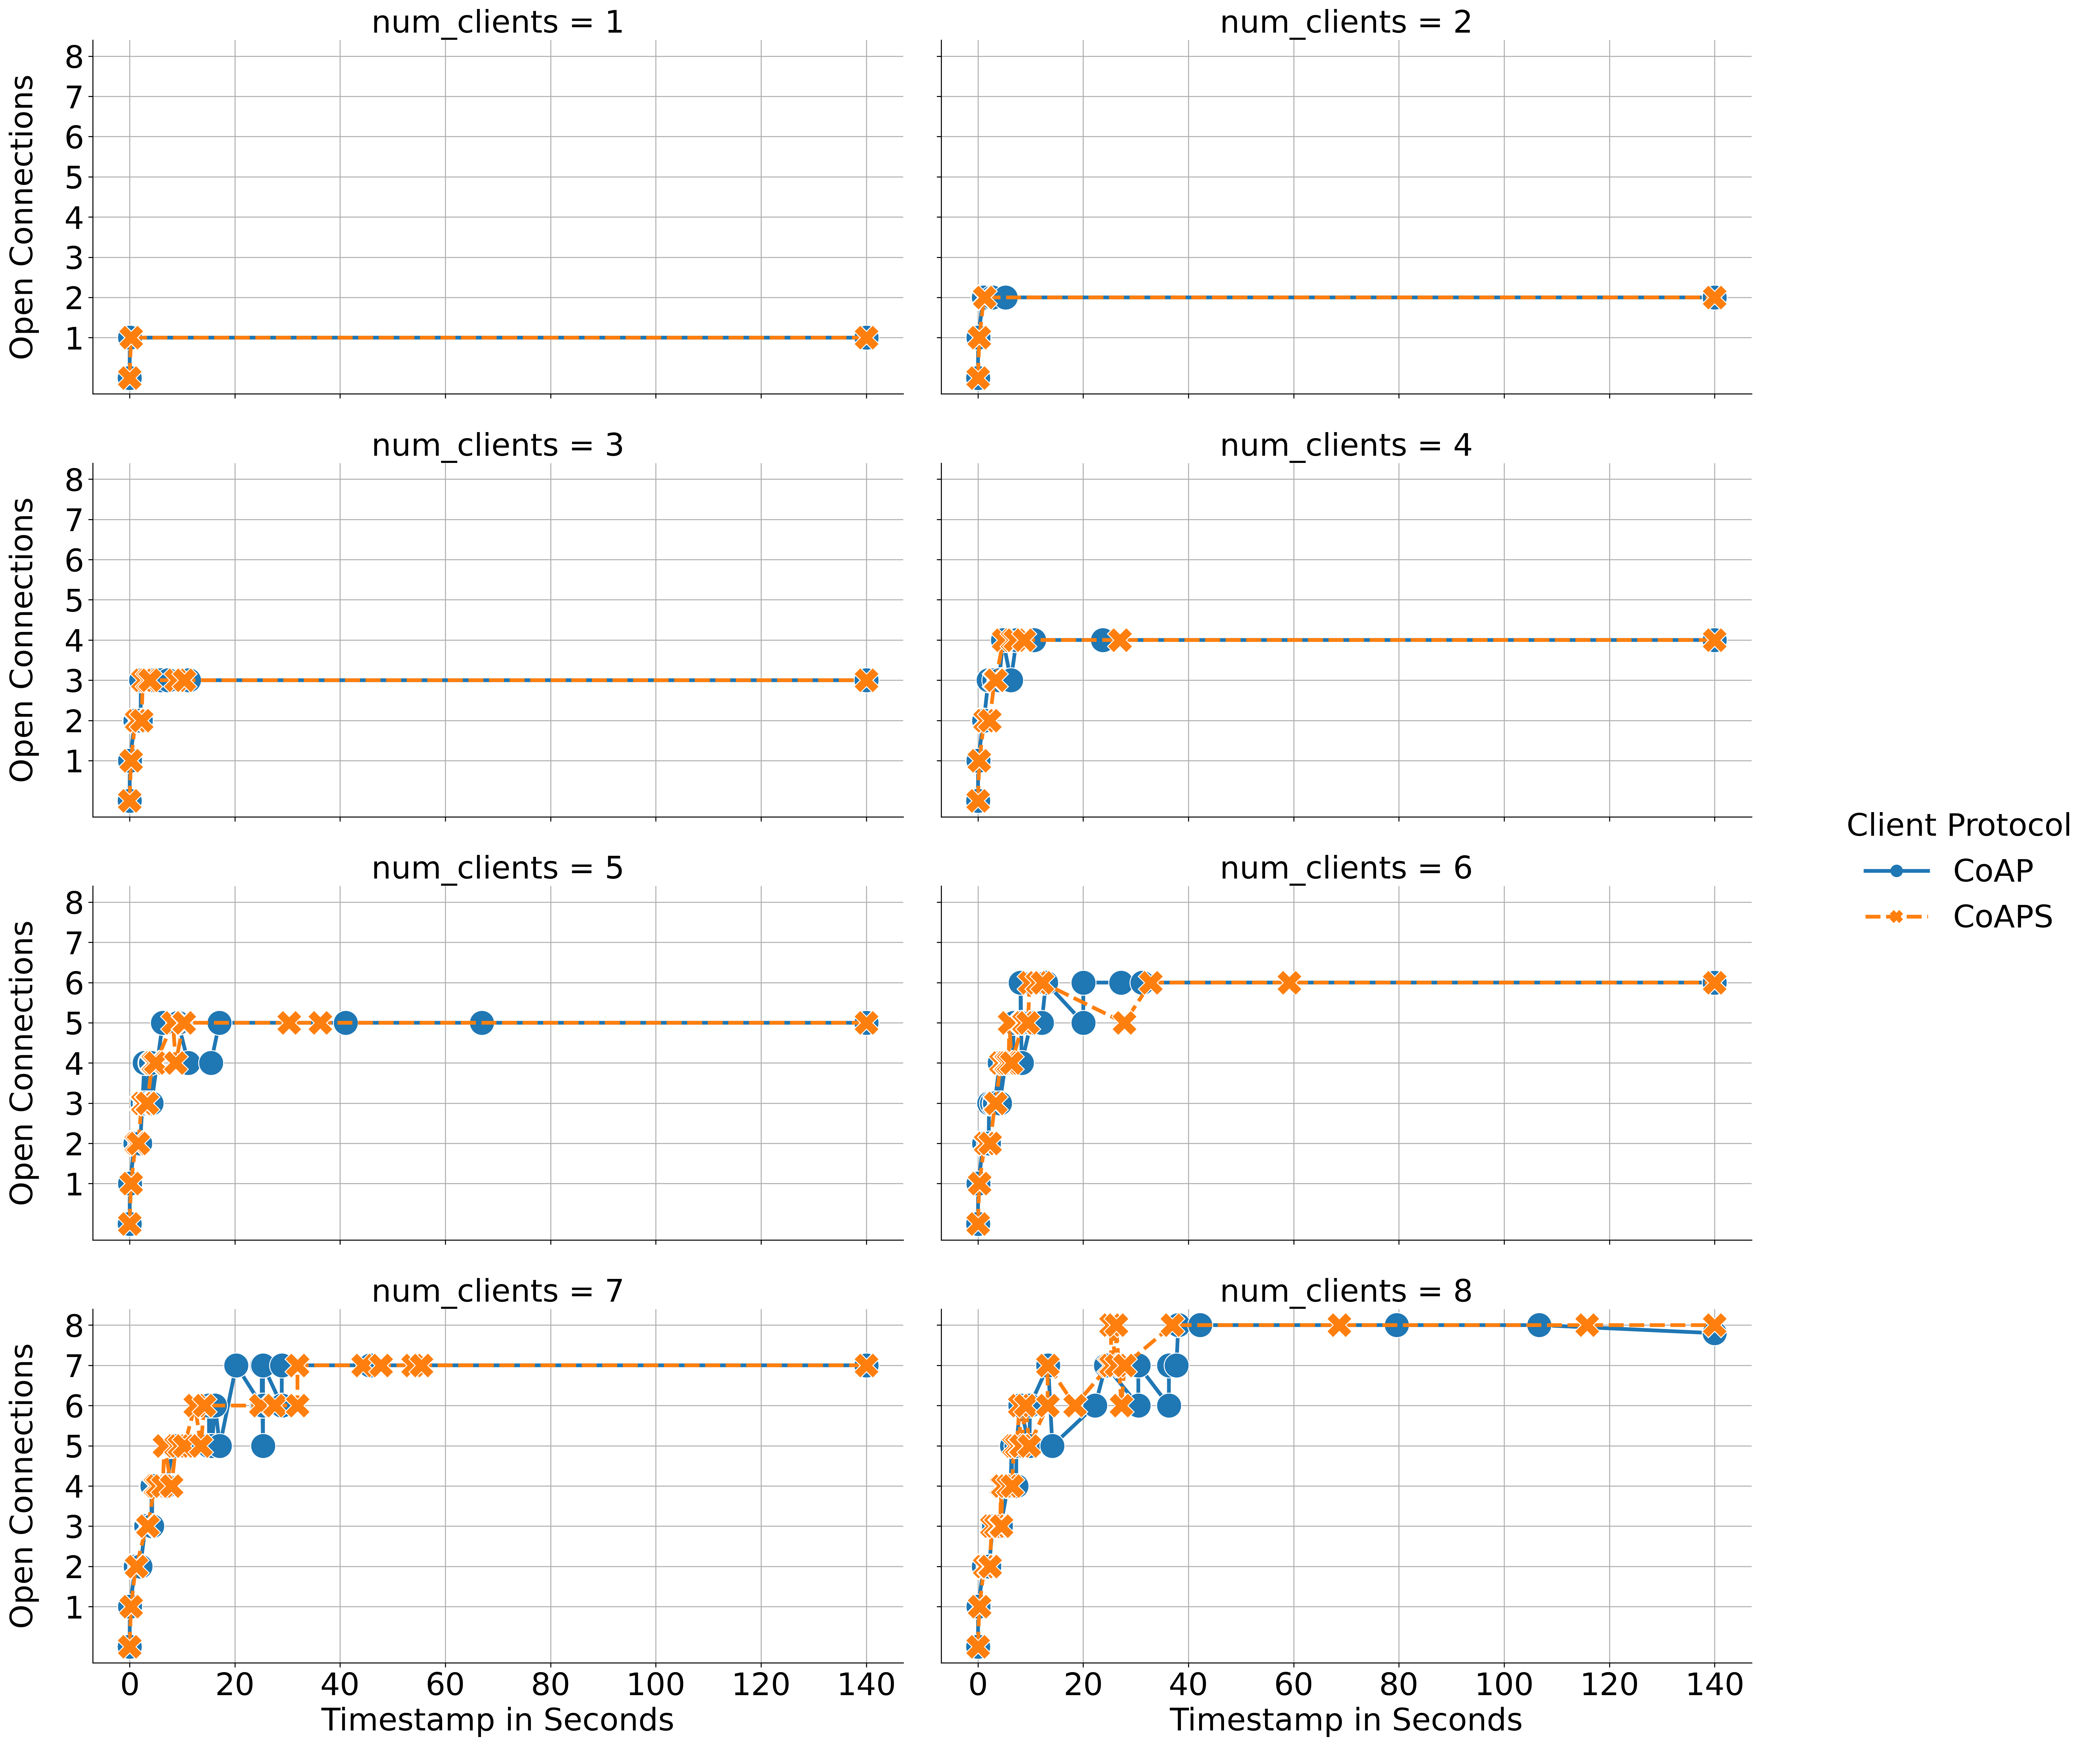

CPU times: user 7.03 s, sys: 1.52 s, total: 8.55 s
Wall time: 8.21 s


In [21]:
%%time

## Measure proxy and server connection management.

df = connections_df

plt.rcParams['font.size'] = '25'

g = sns.relplot(
  data=df,
  kind="line",
  x="timestamp",
  y="open_connections",
  hue="run_proxy_with_dtls",
  style="run_proxy_with_dtls",
  col="num_clients",
  col_wrap=2,
  markers=True,
  markersize=20,
  facet_kws={
    "sharey": True,
    "sharex": True,
  },
  aspect=2,
)
g.set_xlabels("Timestamp in Seconds")
g.set_ylabels("Open Connections", labelpad=20)
g.legend.set_title("Client Protocol")
g.set(yticks=np.arange(1,9,1))
for i in range(8):
  g.axes[i].grid(True, axis="both")

plt.show()

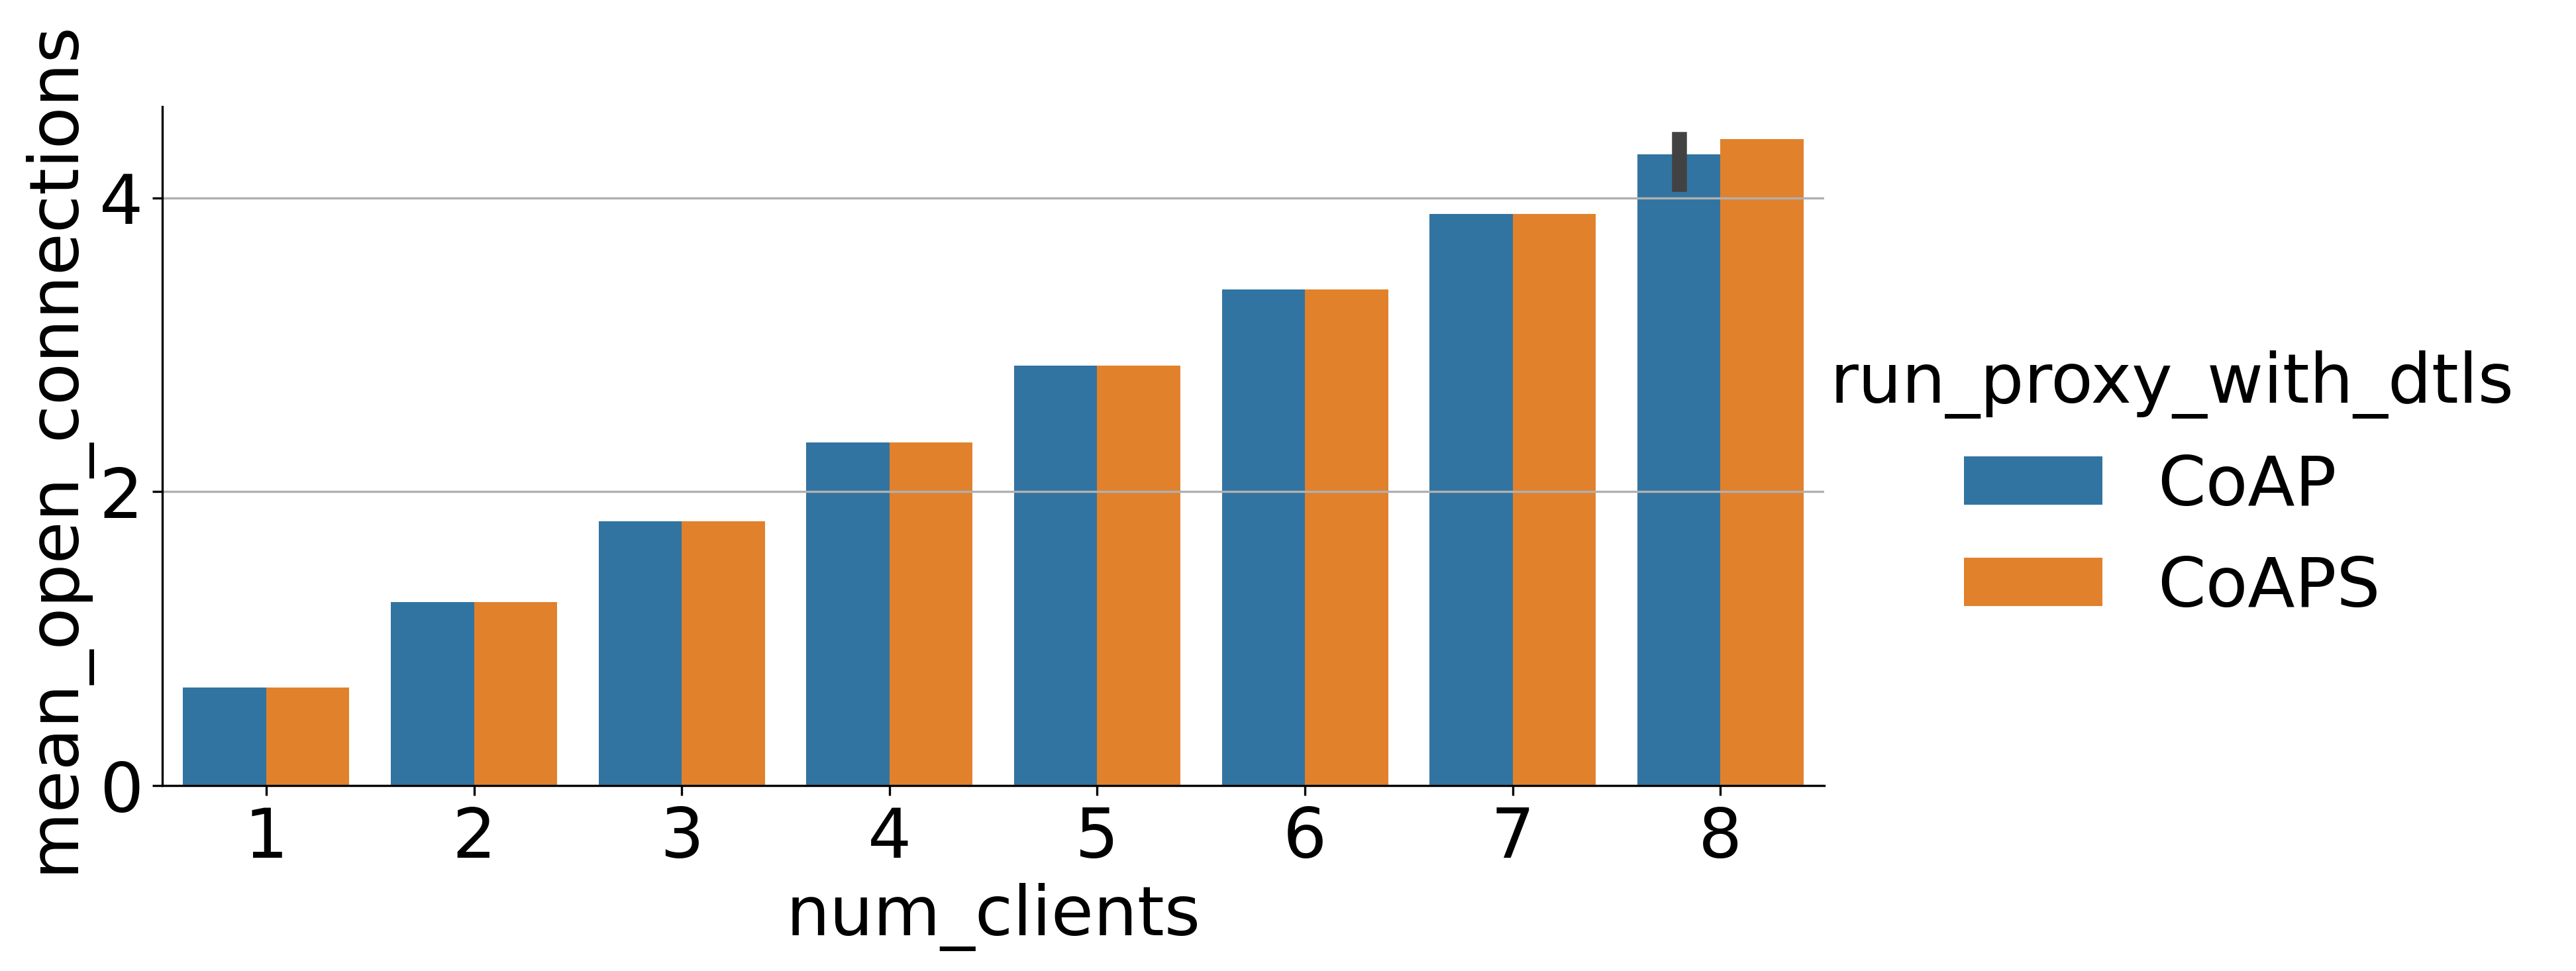

CPU times: user 1.78 s, sys: 199 ms, total: 1.98 s
Wall time: 1.66 s


exp_id  trial  \
0   updated_thesis_group_num_clients_1clients_noattacker_coap_https      1   
1   updated_thesis_group_num_clients_1clients_noattacker_coap_https      2   
2   updated_thesis_group_num_clients_1clients_noattacker_coap_https      3   
3   updated_thesis_group_num_clients_1clients_noattacker_coap_https      4   
4   updated_thesis_group_num_clients_1clients_noattacker_coap_https      5   
..                                                              ...    ...   
75  updated_thesis_group_num_clients_8clients_noattacker_dtls_https      1   
76  updated_thesis_group_num_clients_8clients_noattacker_dtls_https      2   
77  updated_thesis_group_num_clients_8clients_noattacker_dtls_https      3   
78  updated_thesis_group_num_clients_8clients_noattacker_dtls_https      4   
79  updated_thesis_group_num_clients_8clients_noattacker_dtls_https      5   

   observer_id  num_clients run_proxy_with_dtls  mean_open_connections  
0        proxy            1                CoAP               0.666667  
1        proxy            1                CoAP               0.666667  
2        proxy            1                CoAP               0.666667  
3        proxy            1                CoAP               0.666667  
4        proxy            1                CoAP               0.666667  
..         ...          ...                 ...                    ...  
75       proxy            8               CoAPS               4.400000  
76       proxy            8               CoAPS               4.400000  
77       proxy            8               CoAPS               4.400000  
78       proxy            8               CoAPS               4.400000  
79       proxy            8               CoAPS               4.400000  

[80 rows x 6 columns]

In [22]:
%%time

df = (
  connections_df
  .groupby(by=["exp_id", "trial", "observer_id", "num_clients", "run_proxy_with_dtls"])
  .agg(
    mean_open_connections=("open_connections", "mean"),
  )
  .reset_index()
)

g = sns.catplot(
  data=df,
  kind="bar",
  x="num_clients",
  y="mean_open_connections",
  hue="run_proxy_with_dtls",
  aspect=2,
)

plt.grid(True, axis="y")
plt.show()

df

In [46]:
%%time 

client_journey_sql = f"""
WITH client_sends AS (
  SELECT
  dn.exp_id AS exp_id,
  e.observer_id AS observer_id,
  e.observe_timestamp AS observe_timestamp,
  e.trial AS trial,
  e.message_marker AS message_marker
  FROM event e
  JOIN message m ON m.message_id = e.message_id
  JOIN deployed_node dn ON dn.dnid = e.observer_id
  WHERE e.observer_id IN ({','.join(map(str, client_dnids))})   -- client dnids
  AND m.src_id IN ({','.join(map(str, client_node_ids))}) -- clients are senders (node ID)
),

proxy_events AS (
  SELECT
  dn.exp_id AS exp_id,
  e.observe_timestamp AS observe_timestamp,
  e.trial AS trial,
  e.message_marker AS message_marker
  FROM event e
  JOIN deployed_node dn ON dn.dnid = e.observer_id
  WHERE e.observer_id IN ({','.join(map(str, proxy_dnids))})   -- proxy dnids
),

client_recvs AS (
  SELECT
  dn.exp_id AS exp_id,
  e.observer_id AS observer_id,
  e.observe_timestamp AS observe_timestamp,
  e.trial AS trial,
  e.message_marker AS message_marker,
  cm.coap_code AS coap_code
  FROM event e
  JOIN message m ON m.message_id = e.message_id
  JOIN coap_message cm ON cm.cmci = m.coap_message
  JOIN deployed_node dn ON dn.dnid = e.observer_id
  WHERE e.observer_id IN ({','.join(map(str, client_dnids))})   -- client dnids
  AND m.dst_id IN ({','.join(map(str, client_node_ids))}) -- clients are receivers (node ID)
)

SELECT
  client_sends.exp_id AS exp_id,
  client_sends.observer_id AS observer_id,
  client_sends.trial AS trial,
  client_sends.message_marker AS message_marker,
  (groupArray(client_recvs.coap_code))[1] AS coap_code,
  MIN(client_sends.observe_timestamp) AS first_send_time_sec,
  abs(1e3 * (MIN(proxy_events.observe_timestamp) - MIN(client_sends.observe_timestamp))) AS client_to_proxy_ms,
  1e3 * (MAX(client_recvs.observe_timestamp) - MIN(proxy_events.observe_timestamp)) AS proxy_to_client_ms,
  1e3 * (MAX(client_recvs.observe_timestamp) - MIN(client_sends.observe_timestamp)) AS client_to_self_rtt_ms,
  MIN(client_recvs.observe_timestamp) AS first_recv_time_sec
FROM
  client_sends
  JOIN proxy_events
    ON proxy_events.exp_id = client_sends.exp_id
    AND proxy_events.trial = client_sends.trial
    AND proxy_events.message_marker = client_sends.message_marker
  JOIN client_recvs
    ON client_recvs.exp_id = proxy_events.exp_id
    AND client_recvs.trial = proxy_events.trial
    AND client_recvs.message_marker = proxy_events.message_marker
    AND client_recvs.observer_id = client_sends.observer_id
GROUP BY
  client_sends.exp_id, client_sends.observer_id, client_sends.trial, client_sends.message_marker
ORDER BY
  exp_id, trial, message_marker, first_send_time_sec
"""

client_journey_df = client.query_dataframe(client_journey_sql)

client_journey_df.observer_id.replace(dnid_map_node_name, inplace=True)

client_journey_df

CPU times: user 2.28 s, sys: 586 ms, total: 2.87 s
Wall time: 8.25 s


exp_id  \
0       updated_thesis_group_num_clients_1clients_noattacker_coap_https   
1       updated_thesis_group_num_clients_1clients_noattacker_coap_https   
2       updated_thesis_group_num_clients_1clients_noattacker_coap_https   
3       updated_thesis_group_num_clients_1clients_noattacker_coap_https   
4       updated_thesis_group_num_clients_1clients_noattacker_coap_https   
...                                                                 ...   
795038  updated_thesis_group_num_clients_8clients_noattacker_dtls_https   
795039  updated_thesis_group_num_clients_8clients_noattacker_dtls_https   
795040  updated_thesis_group_num_clients_8clients_noattacker_dtls_https   
795041  updated_thesis_group_num_clients_8clients_noattacker_dtls_https   
795042  updated_thesis_group_num_clients_8clients_noattacker_dtls_https   

       observer_id  trial  message_marker coap_code  first_send_time_sec  \
0          client1      1               1   content             0.000000   
1          client1      1               2   content             0.379414   
2          client1      1               3   content             0.441283   
3          client1      1               4   content             0.502526   
4          client1      1               5   content             0.561645   
...            ...    ...             ...       ...                  ...   
795038     client8      5           17711   content           125.790500   
795039     client8      5           17712   content           125.844201   
795040     client8      5           17713   content           125.897814   
795041     client8      5           17714   content           125.951450   
795042     client8      5           17715   content           126.004981   

        client_to_proxy_ms  proxy_to_client_ms  client_to_self_rtt_ms  \
0                20.425081          343.944788             364.369869   
1                20.419836           39.258957              59.678793   
2                20.308971           38.800955              59.109926   
3                20.416975           36.376953              56.793928   
4                20.416975           35.717010              56.133986   
...                    ...                 ...                    ...   
795038           20.609140           32.373905              52.983046   
795039           20.607948           32.248020              52.855968   
795040           20.572901           32.160997              52.733898   
795041           20.608902           32.150984              52.759886   
795042           20.606041           32.420874              53.026915   

        first_recv_time_sec  
0                  0.364370  
1                  0.439093  
2                  0.500393  
3                  0.559320  
4                  0.617779  
...                     ...  
795038           125.843483  
795039           125.897057  
795040           125.950548  
795041           126.004210  
795042           126.058008  

[795043 rows x 10 columns]

In [47]:
%%time

# `client_journey_df` is far too detailed for plotting, but
# is useful for non-plotting use-cases so we keep it around.
# But for plotting, we summarize RTTs in discrete intervals
# of time instead, thus reducing the amount of data.

reduced_client_journey_df = (
  client_journey_df
  .groupby(by=[
    "exp_id", "observer_id", "trial",
    pd.cut(client_journey_df["first_send_time_sec"], np.arange(0,121,5))
  ])
  .agg(
    client_to_proxy_ms=("client_to_proxy_ms", "mean"),
    proxy_to_client_ms=("proxy_to_client_ms", "mean"),
    client_to_self_rtt_ms=("client_to_self_rtt_ms", "mean"),
  )
  .reset_index()
  .melt(
    id_vars=["exp_id", "observer_id", "trial", "first_send_time_sec"],
    value_vars=["client_to_proxy_ms", "proxy_to_client_ms", "client_to_self_rtt_ms"],
    var_name="sub_journey_name",
    value_name="sub_journey_time_ms",
  )
)

reduced_client_journey_df["first_send_time_sec"] = reduced_client_journey_df["first_send_time_sec"].map(operator.attrgetter("right"))
reduced_client_journey_df = reduced_client_journey_df.merge(exp_df, on="exp_id", how="left")

reduced_client_journey_df

CPU times: user 1.07 s, sys: 4.21 ms, total: 1.07 s
Wall time: 1.07 s


exp_id  \
0      updated_thesis_group_num_clients_1clients_noattacker_coap_https   
1      updated_thesis_group_num_clients_1clients_noattacker_coap_https   
2      updated_thesis_group_num_clients_1clients_noattacker_coap_https   
3      updated_thesis_group_num_clients_1clients_noattacker_coap_https   
4      updated_thesis_group_num_clients_1clients_noattacker_coap_https   
...                                                                ...   
46075  updated_thesis_group_num_clients_8clients_noattacker_dtls_https   
46076  updated_thesis_group_num_clients_8clients_noattacker_dtls_https   
46077  updated_thesis_group_num_clients_8clients_noattacker_dtls_https   
46078  updated_thesis_group_num_clients_8clients_noattacker_dtls_https   
46079  updated_thesis_group_num_clients_8clients_noattacker_dtls_https   

      observer_id  trial first_send_time_sec       sub_journey_name  \
0         client1      1                   5     client_to_proxy_ms   
1         client1      1                  10     client_to_proxy_ms   
2         client1      1                  15     client_to_proxy_ms   
3         client1      1                  20     client_to_proxy_ms   
4         client1      1                  25     client_to_proxy_ms   
...           ...    ...                 ...                    ...   
46075     client8      5                 100  client_to_self_rtt_ms   
46076     client8      5                 105  client_to_self_rtt_ms   
46077     client8      5                 110  client_to_self_rtt_ms   
46078     client8      5                 115  client_to_self_rtt_ms   
46079     client8      5                 120  client_to_self_rtt_ms   

       sub_journey_time_ms attacker_rate  server_connections  \
0                20.396689         0mbps                 256   
1                20.391840         0mbps                 256   
2                20.394016         0mbps                 256   
3                20.392360         0mbps                 256   
4                20.367353         0mbps                 256   
...                    ...           ...                 ...   
46075            52.573953         0mbps                 256   
46076            52.697836         0mbps                 256   
46077            52.633250         0mbps                 256   
46078            52.605462         0mbps                 256   
46079            52.636390         0mbps                 256   

       max_keep_alive_requests  num_clients  ...  \
0                            0            1  ...   
1                            0            1  ...   
2                            0            1  ...   
3                            0            1  ...   
4                            0            1  ...   
...                        ...          ...  ...   
46075                        0            8  ...   
46076                        0            8  ...   
46077                        0            8  ...   
46078                        0            8  ...   
46079                        0            8  ...   

                                  topology_name  num_proxy_connections  \
0      thesis_cloud_proxy_and_internet_attacker                     50   
1      thesis_cloud_proxy_and_internet_attacker                     50   
2      thesis_cloud_proxy_and_internet_attacker                     50   
3      thesis_cloud_proxy_and_internet_attacker                     50   
4      thesis_cloud_proxy_and_internet_attacker                     50   
...                                         ...                    ...   
46075  thesis_cloud_proxy_and_internet_attacker                     50   
46076  thesis_cloud_proxy_and_internet_attacker                     50   
46077  thesis_cloud_proxy_and_internet_attacker                     50   
46078  thesis_cloud_proxy_and_internet_attacker                     50   
46079  thesis_cloud_proxy_and_internet_attacker                     50   

       request_timeout  max_retries  ke

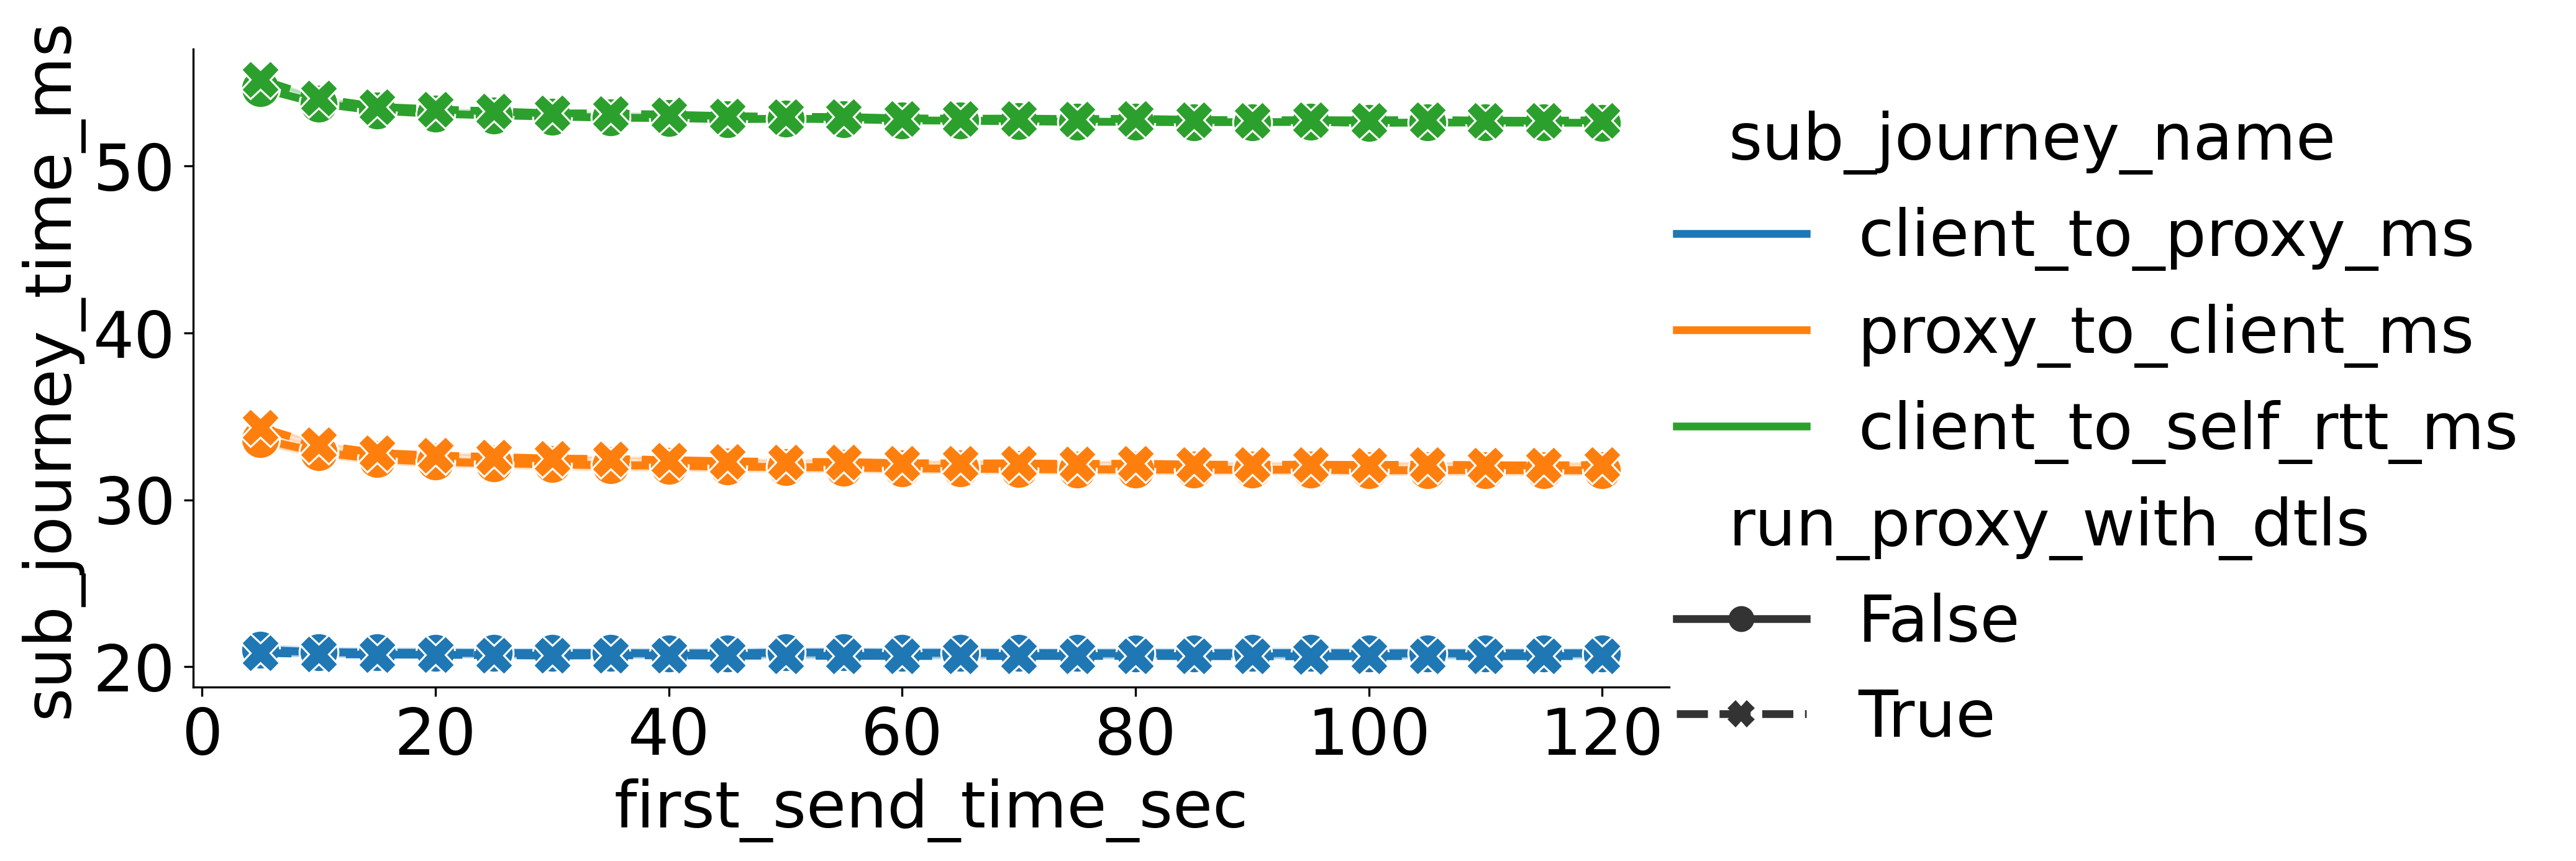

CPU times: user 5.9 s, sys: 127 ms, total: 6.03 s
Wall time: 5.7 s


In [48]:
%%time

## Plot different stages of the client round-trip.

df = reduced_client_journey_df

g = sns.relplot(
  data=df,
  kind="line",
  x="first_send_time_sec",
  y="sub_journey_time_ms",
  hue="sub_journey_name",
  style="run_proxy_with_dtls",
  # col="num_clients",
  # col_wrap=2,
  markers=True,
  markersize=15,
  aspect=2,
)

plt.show()

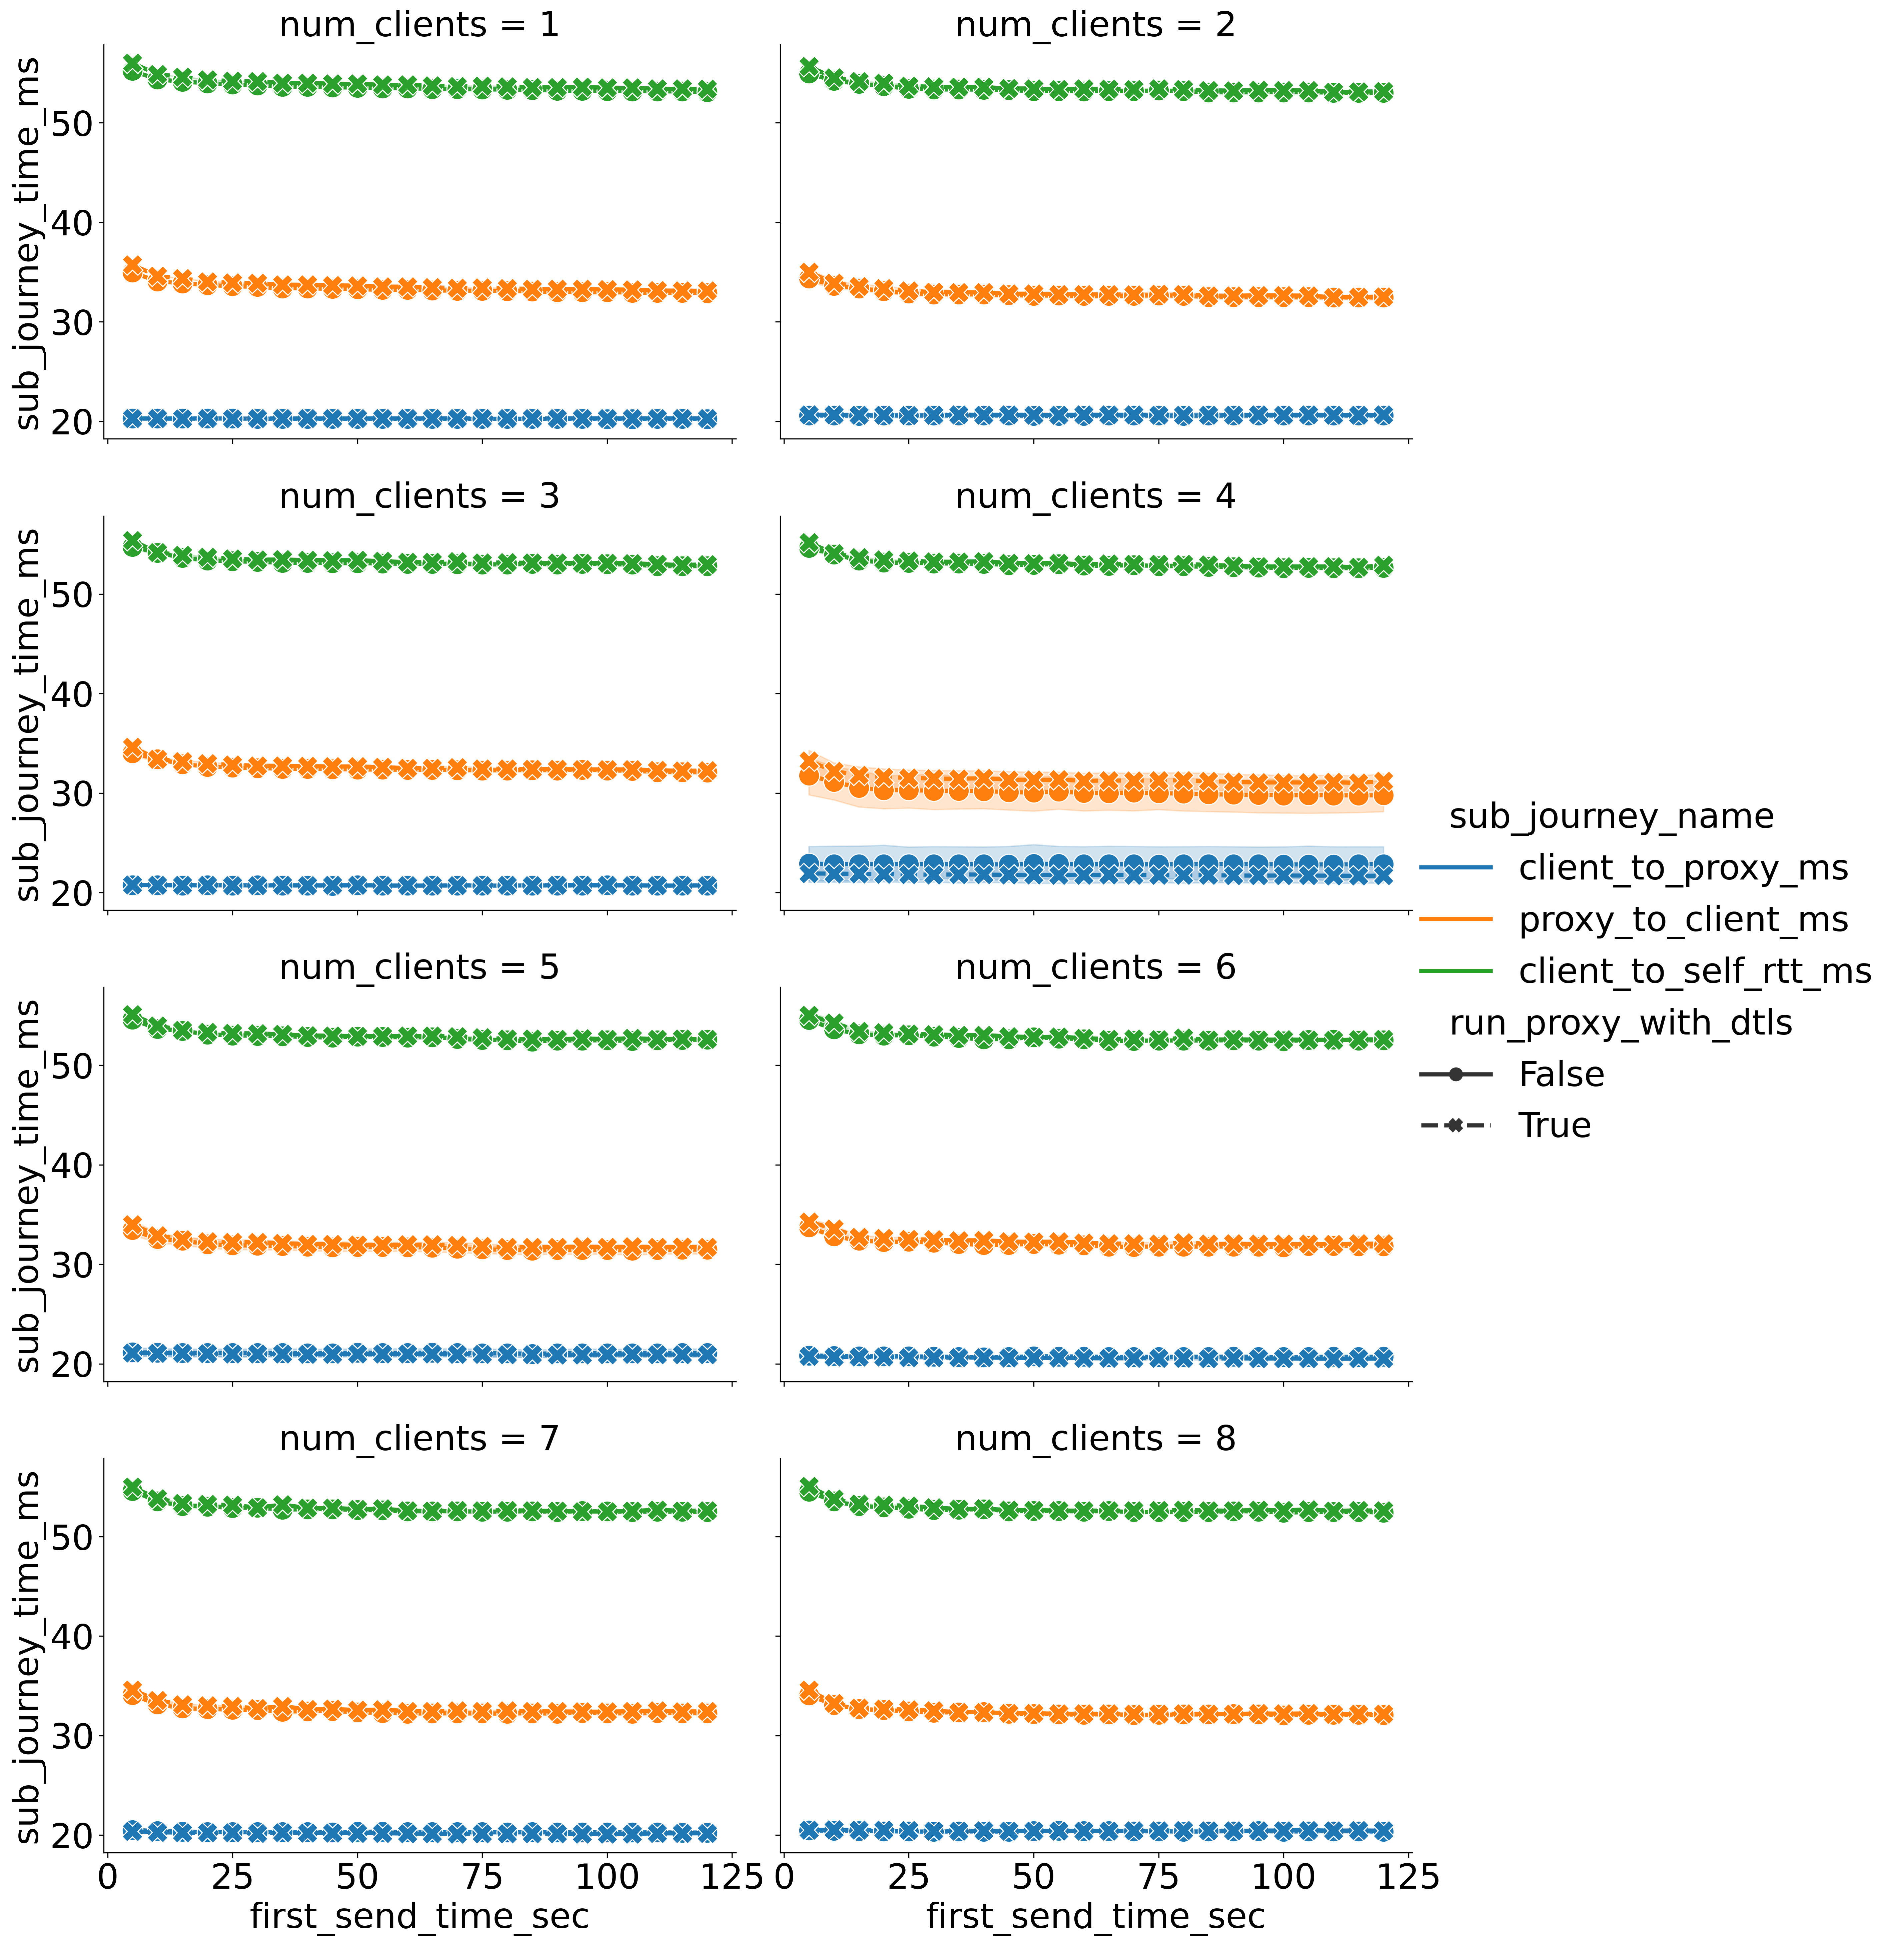

CPU times: user 40.1 s, sys: 1.15 s, total: 41.3 s
Wall time: 40.9 s


In [ ]:
%%time

df = reduced_client_journey_df

g = sns.relplot(
  data=df,
  kind="line",
  x="first_send_time_sec",
  y="sub_journey_time_ms",
  hue="sub_journey_name",
  style="run_proxy_with_dtls",
  col="num_clients",
  col_wrap=2,
  markers=True,
  markersize=20,
  aspect=1.5,
)

plt.show()

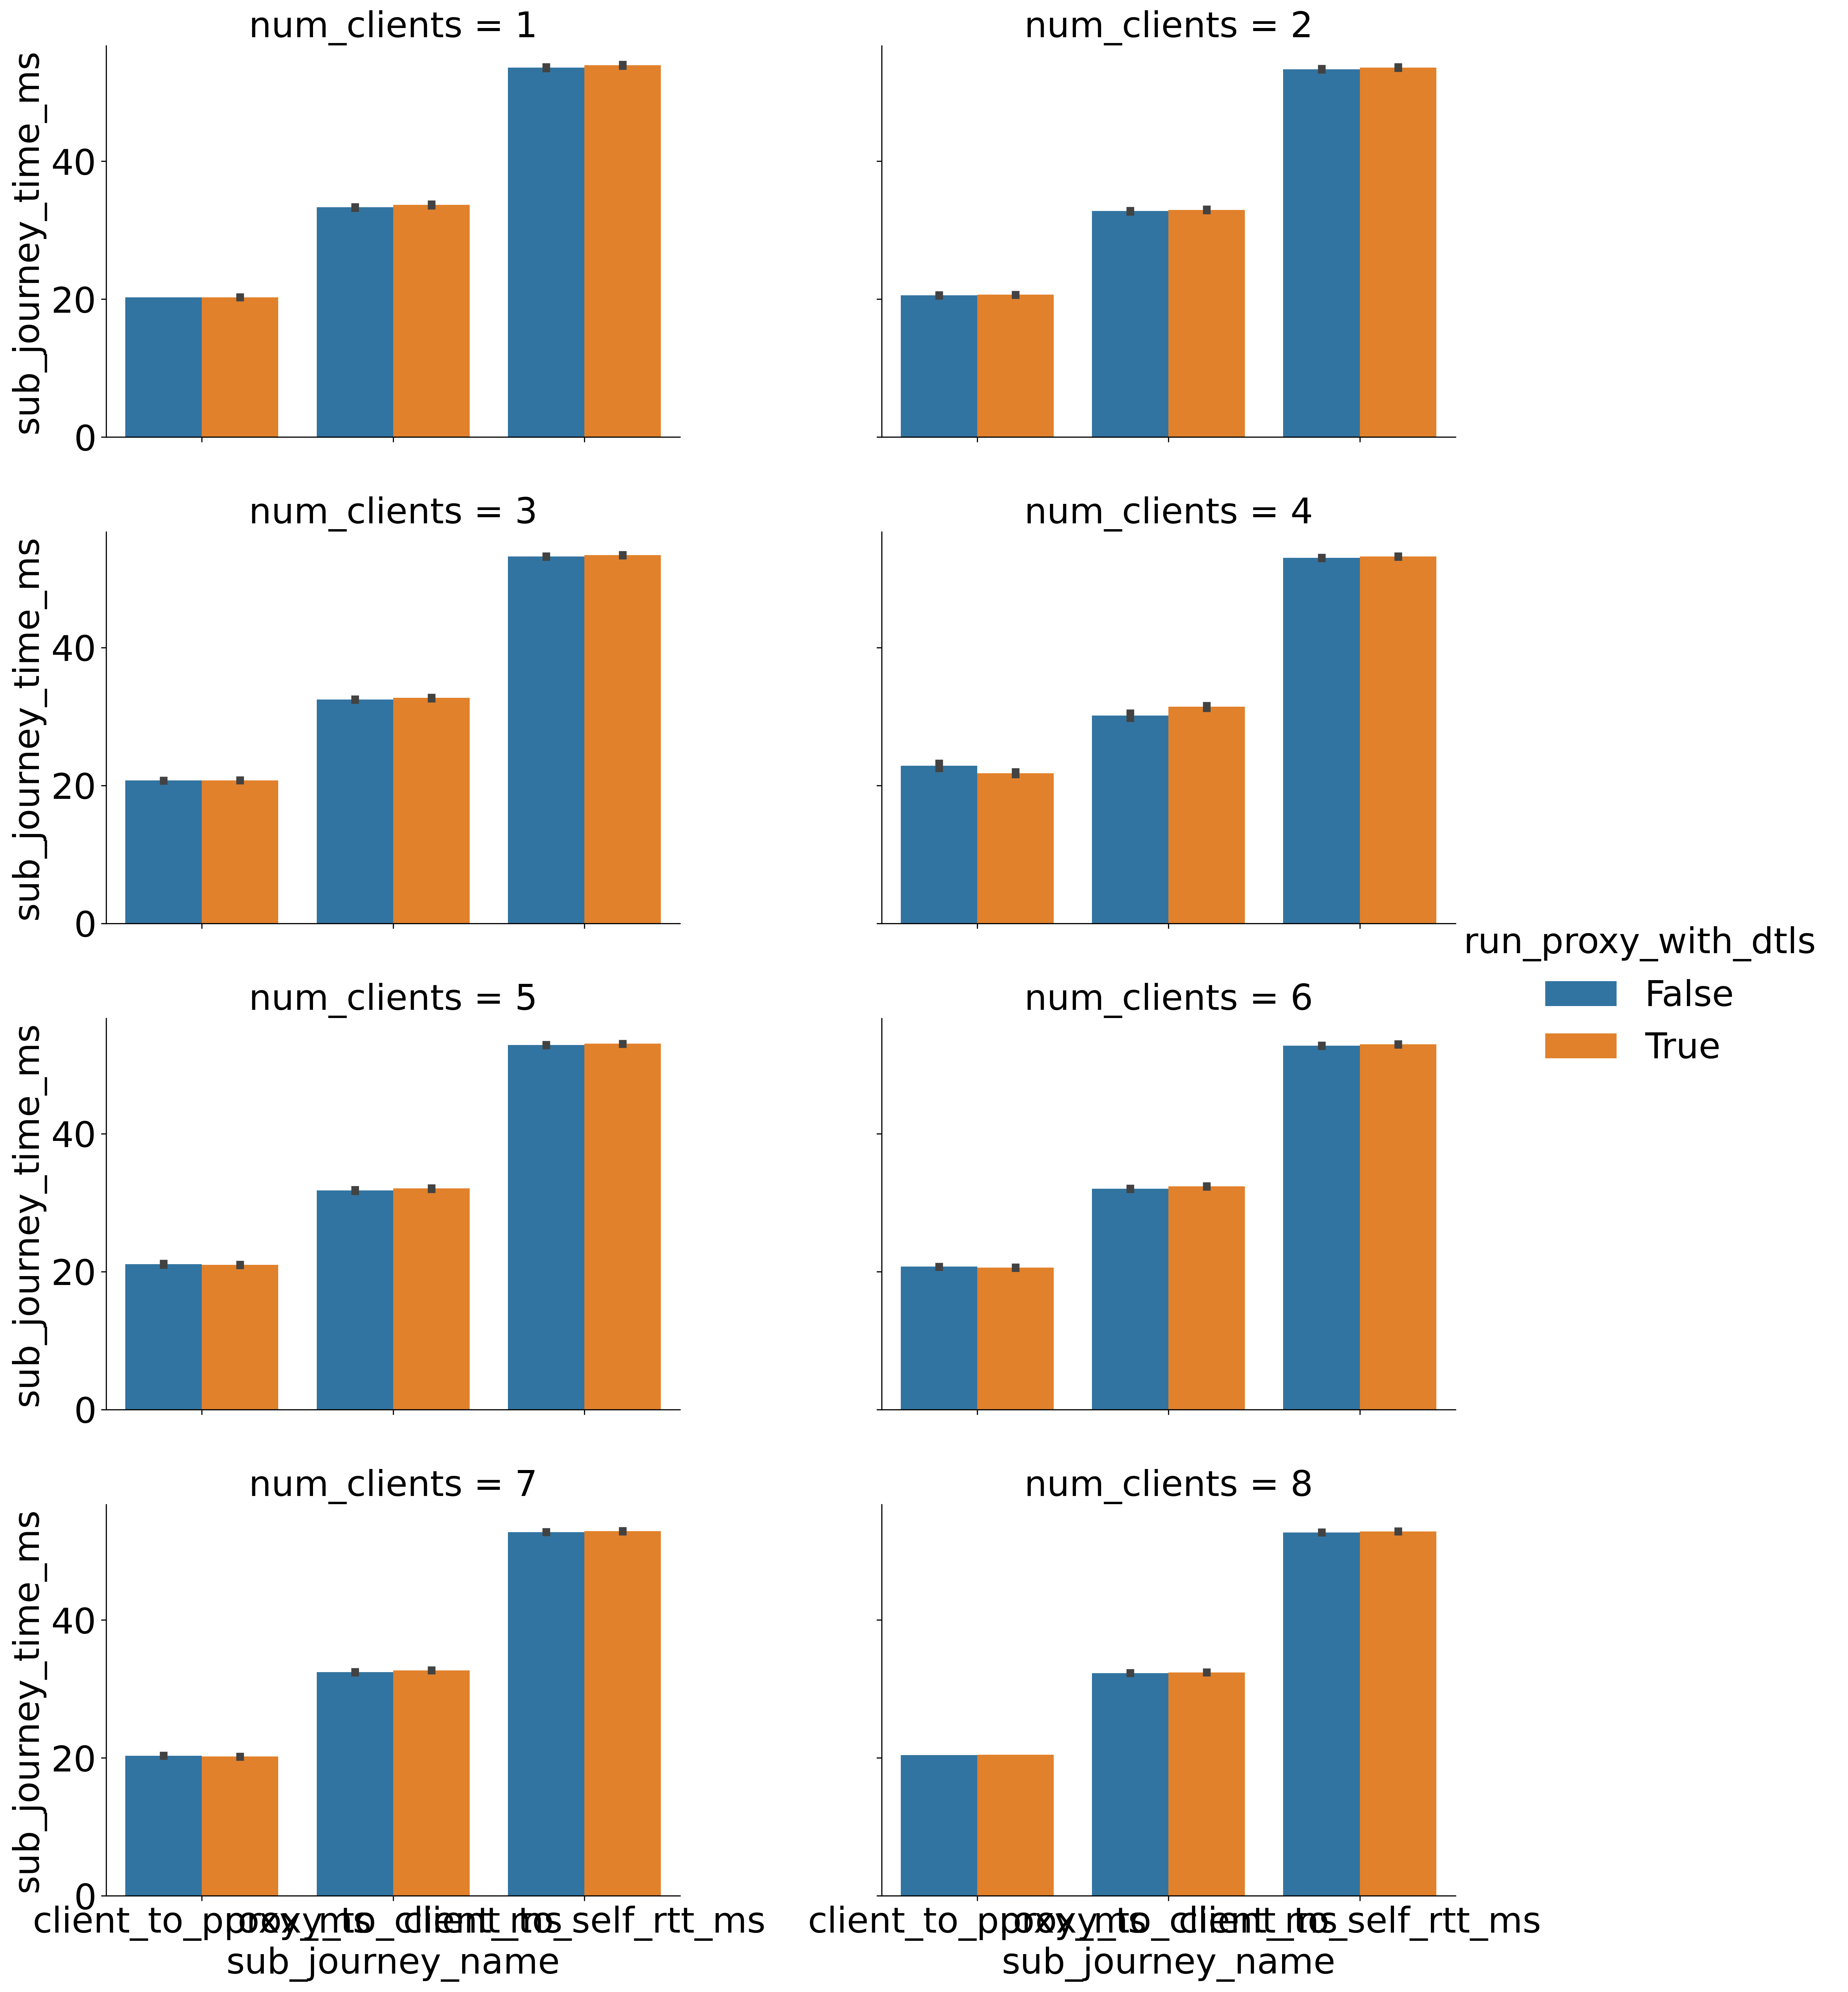

CPU times: user 5.79 s, sys: 1.08 s, total: 6.87 s
Wall time: 6.57 s


In [ ]:
%%time

df = reduced_client_journey_df

g = sns.catplot(
  data=df,
  kind="bar",
  x="sub_journey_name",
  y="sub_journey_time_ms",
  hue="run_proxy_with_dtls",
  col="num_clients",
  col_wrap=2,
  aspect=1.5,
)

plt.show()

In [57]:
%%time

patterns_sql = f"""
WITH message_patterns AS (
  SELECT
    e.observer_id AS observer_id,
    m.message_id AS message_id,
    m.src_id AS src_id,
    m.dst_id AS dst_id
  FROM
    event e
    JOIN message m ON m.message_id = e.message_id
  GROUP BY
  observer_id, message_id, src_id, dst_id
)

SELECT * FROM message_patterns
"""

patterns_df = client.query_dataframe(patterns_sql)

patterns_df.replace({
  "observer_id": dnid_map_node_name,
  "src_id": node_id_map_node_name,
  "dst_id": node_id_map_node_name,
}, inplace=True)

patterns_df

CPU times: user 45.1 ms, sys: 4.34 ms, total: 49.4 ms
Wall time: 748 ms


observer_id  message_id        src_id dst_id
0       client1           3       client1  proxy
1       client1           8       client1  proxy
2       client1           9       client1  proxy
3       client2          16       client2  proxy
4         proxy          82  originserver  proxy
..          ...         ...           ...    ...
795       proxy          44       client5  proxy
796       proxy          11       client2  proxy
797     client2          11       client2  proxy
798       proxy          19       client2  proxy
799       proxy          30       client3  proxy

[800 rows x 4 columns]

In [59]:
observer = lambda df, name : df["observer_id"].str.contains(name)
sender = lambda df, name : df["src_id"].str.contains(name)
receiver = lambda df, name : df["dst_id"].str.contains(name)

client_to_proxy = lambda df : df[
  (observer(df, "client")) 
  & (sender(df, "client")) 
  & (receiver(df, "proxy"))
]

client_to_proxy(patterns_df)

observer_id  message_id   src_id dst_id
0       client1           3  client1  proxy
1       client1           8  client1  proxy
2       client1           9  client1  proxy
3       client2          16  client2  proxy
11      client2          13  client2  proxy
..          ...         ...      ...    ...
784     client4          31  client4  proxy
785     client4          33  client4  proxy
788     client1           1  client1  proxy
792     client1           6  client1  proxy
797     client2          11  client2  proxy

[288 rows x 4 columns]